In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize
# nelder-mead optimization of noisy one-dimensional convex function
from scipy.optimize import minimize
from numpy.random import rand
from scipy import interpolate
import itertools
import time
from scipy import signal
import datetime
from datetime import timedelta, date
from scipy.interpolate import InterpolatedUnivariateSpline
import seaborn as sns
from matplotlib.figure import figaspect
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import numpy.ma as ma
import scipy.interpolate as spinterp
import itertools

In [2]:
import math

In [3]:
C2=3.731e-5
C3=5.71e-14
Q=5*999#10*999
beta=2
H=350

In [4]:
m=C2*Q**(3/5)*np.sin(beta*np.pi/180)**(6/5)
m

0.00011023754712179421

In [5]:
r=C3*((Q**(2/5))/(np.sin(beta*np.pi/180)**(1/5)))*H**3
r

0.00014444103959498968

In [6]:
m/r

0.7632010087361494

In [7]:
path_df_export = '/home/colili/Documents/PhD/ploughmeter_project/processing_2122/Dataframe_produced/Dataframe_clean/diurnal/'
path_fig_export = '/home/colili/Documents/PhD/ploughmeter_project/processing_2122/Figure/Figure_clean_paper/band_pass_diurnal/'

# Import the dataframe 

In [8]:
df_data_raw = pd.read_csv('/home/colili/Documents/PhD/ploughmeter_project/processing_2122/Dataframe_produced/Dataframe_clean/raw_data_3H/df_all_data_3H.csv',
                     sep=',', header=[0], parse_dates=[0])

In [9]:
# df_data.info()

In [10]:
df_data = df_data_raw[['Time','TIMESTAMP', 'L', 'Pe', 'P3-10', 'P30-45', 'R', 'S', 'Runoff']]

In [11]:
df_data.columns=['Time','TIMESTAMP', 'L', 'Pe', 'P3_10', 'P30_45', 'R', 'S', 'Runoff']

# Split data to have the melt season 2021 and 2022 in two dataframes

In [12]:
df_melt_2021=df_data[128:896]

In [13]:
df_melt_2022=df_data[2753:3423]

In [14]:
df_winter_2122 = df_data[896:2753]

# Band pass filter of the data between 6h and 36h days

In [15]:
df = [df_melt_2021, df_melt_2022]
name = ['melt_2021', 'melt_2022']
for d in np.arange(0, len(df)):
    df_temp = df[d]

    for i in np.arange(2, df_temp.shape[1]):
        idx = np.isfinite(df_temp[df_temp.columns[i]])
        fit= np.polyfit(np.arange(df_temp.index[idx].shape[0]), df_temp[df_temp.columns[i]][idx], deg=1)
        function= np.poly1d(fit)
        globals()[f'fit_%s_{name[d]}'%df_temp.columns[i]]=function(df_temp.index[idx].shape[0])

In [16]:
# df = [df_melt_2021, df_melt_2022]
# name = ['melt_2021', 'melt_2022']
# for d in np.arange(0, len(df)):
#     df_temp = df[d]
#     for i in np.arange(2, df_temp.shape[1]):
#         idx = np.isfinite(df_temp[df_temp.columns[i]])
#         globals()[f'filterbandpass_%s_diurnal_{name[d]}'%df_temp.columns[i]]=signal.filtfilt(b, a, df_temp[df_temp.columns[i]][idx])

In [17]:
df_melt_2021['L'][128]

95.34368051751484

In [18]:
ts=df_data['Time'][1]-df_data['Time'][0]
fs = 1/ts

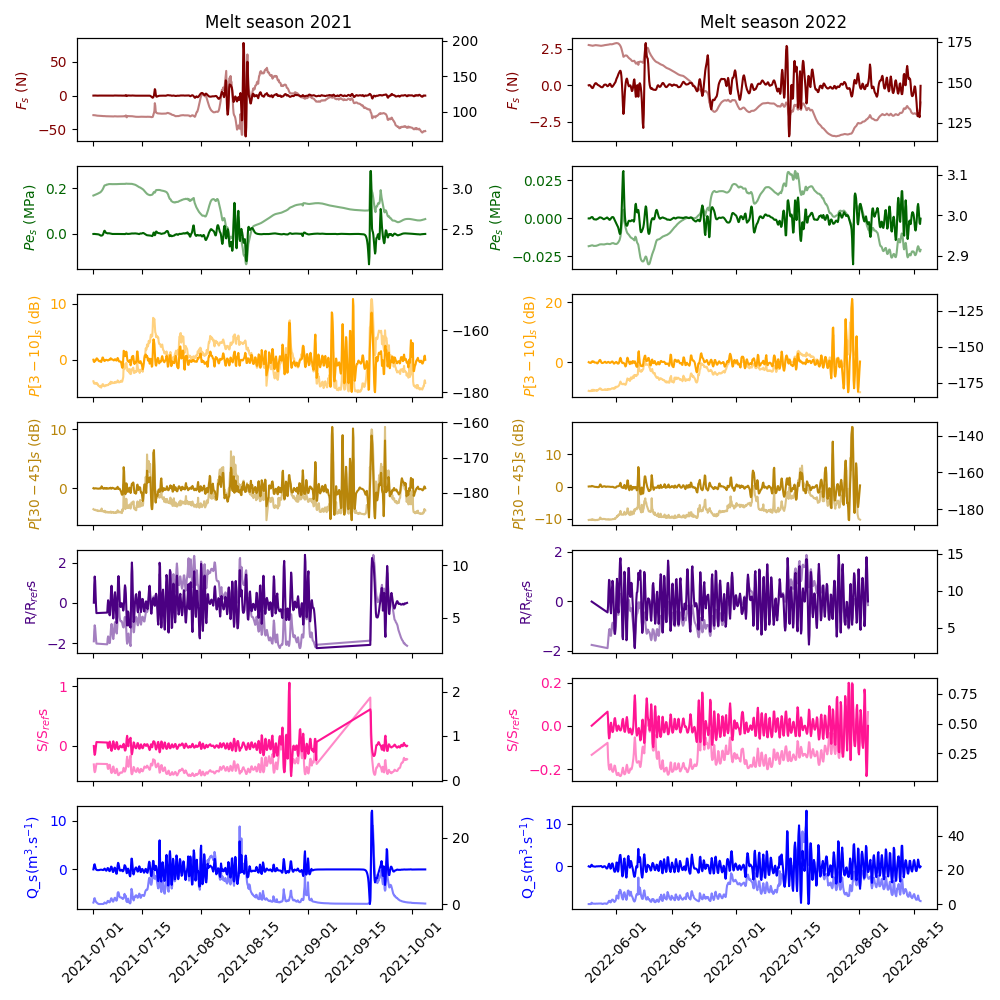

In [19]:
%matplotlib widget
b = signal.butter(1, [1/1.5, 1/0.25]/fs, 'band')[0]
a = signal.butter(1, [1/1.5, 1/0.25]/fs, 'band')[1]

# b = signal.butter(1, 1/20/fs, 'low')[0]
# a = signal.butter(1, 1/20/fs, 'low')[1]

df = [df_melt_2021, df_melt_2022]
name = ['melt_2021', 'melt_2022']
for d in np.arange(0, len(df)):
    df_temp = df[d]
    for i in np.arange(2, df_temp.shape[1]):
        idx = np.isfinite(df_temp[df_temp.columns[i]])
        globals()[f'filterbandpass_%s_diurnal_{name[d]}'%df_temp.columns[i]]=signal.filtfilt(b, a, df_temp[df_temp.columns[i]][idx])


color = ['maroon', 'darkgreen', 'orange', 'darkgoldenrod', 'indigo', 'deeppink', 'b',]
label = ['$F_{s}$ (N)', r'$Pe_{s}$ (MPa)', r'$P[3-10]_{s}$ (dB)', r'$P[30-45]{s}$ (dB)', 'R/R$_{ref}$s', 'S/S$_{ref}$s', 'Q_s(m$^3$.s$^{-1}$)']
label_raw = ['F (N)', 'Pe (MPa)', 'P [3-10] (dB)', 'P [30-45 Hz] (dB)', 'R/R$_{ref}$', 'S/S$_{ref}$', 'Q (m$^3$.s$^{-1}$)']
# label = ['L (N)', 'Pe (MPa)', 'P [3-10] (dB)', 'P [30-45 Hz] (dB)', 'R/R$_{ref}$', 'S/S$_{ref}$', 'Q (m$^3$.s$^{-1}$)']
# df = [df_melt_2021, df_melt_2022]
# name = ['melt_2021', 'melt_2022']
date = ['2021-06-24 00:00:00', '2021-07-01 00:00:00']

fig, axs = plt.subplots(df_data.shape[1]-2, 2, figsize=(10, 10), sharex='col')

for d in np.arange(0, len(df)):
    df_temp = df[d]
    
    for i in np.arange(2, df_temp.shape[1]):
        # print(df_temp.columns[i])

        idx = np.isfinite(df_temp[df_temp.columns[i]])

        data = globals()[f'filterbandpass_%s_diurnal_{name[d]}'%df_temp.columns[i]]

        
        globals()[f'df_filter_diurnal_{df_temp.columns[i]}_{name[d]}']=pd.DataFrame({'TIMESTAMP':df_temp['TIMESTAMP'][idx], 
                                                                          str(df_temp.columns[i]):data})
        globals()[f'df_filter_diurnal_{df_temp.columns[i]}_{name[d]}'].to_csv(path_df_export+f'diurnal_band_pass/df_filter_diurnal_norm_{df_temp.columns[i]}_{name[d]}.csv')
        axs[i-2][d].plot(df_temp['TIMESTAMP'][idx], data, color[i-2])
        axs[i-2][d].set_ylabel(label[i-2], color=color[i-2])
        axs[i-2][d].tick_params(axis='y', labelcolor=color[i-2])
        axs[i-2][d].tick_params(axis='x', rotation=45)

        ax1=axs[i-2][d].twinx()
        ax1.plot(df_temp['TIMESTAMP'][idx], df_temp[df_temp.columns[i]][idx], color[i-2], alpha=0.5)
            
    globals()[f'df_filter_diurnal_{df_temp.columns[i]}_{name[d]}'].to_csv(path_df_export+f'diurnal_band_pass/df_filter_diurnal_norm_{name[d]}.csv')
    

               
    
axs[0][0].text(0.35, 1.1, 'Melt season 2021', 
    color='k', 
    fontsize=12, 
    transform=axs[0][0].transAxes)
axs[0][1].text(0.35, 1.1, 'Melt season 2022', 
    color='k', 
    fontsize=12, 
    transform=axs[0][1].transAxes)

plt.tight_layout()
plt.savefig(path_fig_export+'bandpass_diurnal.pdf', bbox_inches='tight')


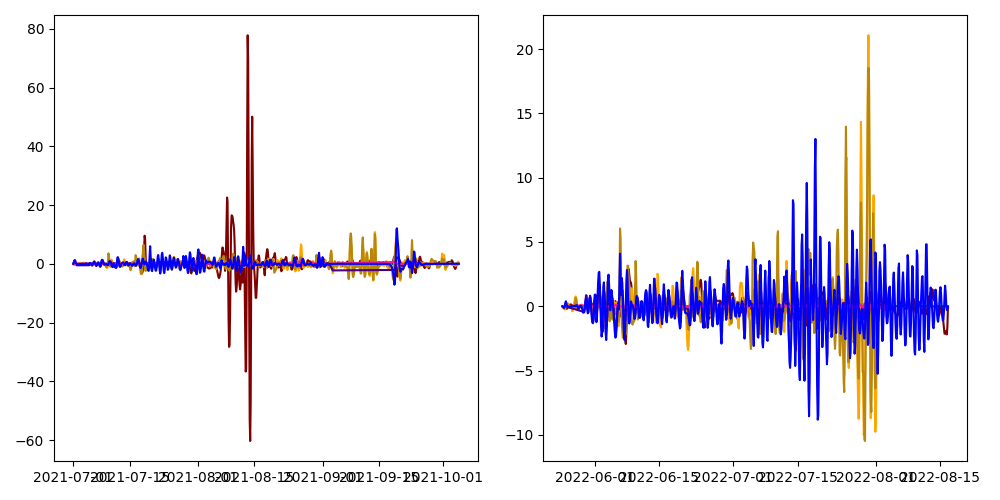

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
for d in np.arange(0, len(df)):   
    df_temp=df[d]
    for i in np.arange(2, df_temp.shape[1]):
        # print(globals()[f'df_filter_3D_{df_temp.columns[i]}_{name[d]}']['TIMESTAMP'])
        # print(idx)
        axs[d].plot(globals()[f'df_filter_diurnal_{df_temp.columns[i]}_{name[d]}']['TIMESTAMP'],
                    globals()[f'df_filter_diurnal_{df_temp.columns[i]}_{name[d]}'][df_temp.columns[i]],
                   color=color[i-2])
plt.tight_layout()
plt.savefig(path_fig_export+'bandpass_diurnal_comp.pdf', bbox_inches='tight')

## Handpicking index where there is multi-day variations

### Give same index value to all dataframe based on df_melt

In [21]:
for d in np.arange(0, len(df)):   
    df_temp=df[d]
    
    for i in np.arange(2, df_temp.shape[1]):
        df_temp_value=globals()[f'df_filter_diurnal_{df_temp.columns[i]}_{name[d]}']
        globals()[f'df_filter_diurnal_{df_temp.columns[i]}_{name[d]}']=pd.concat([df_temp_value, df_temp], axis=1).iloc[:, [3,1]]

## Melt 2021

### Reindex dataframe

In [22]:
df_filter_diurnal_L_melt_2021.reset_index(inplace=True, drop=True)
df_filter_diurnal_Pe_melt_2021.reset_index(inplace=True, drop=True)
df_filter_diurnal_P3_10_melt_2021.reset_index(inplace=True, drop=True)
df_filter_diurnal_P30_45_melt_2021.reset_index(inplace=True, drop=True)
df_filter_diurnal_R_melt_2021.reset_index(inplace=True, drop=True)
df_filter_diurnal_S_melt_2021.reset_index(inplace=True, drop=True)
df_filter_diurnal_Runoff_melt_2021.reset_index(inplace=True, drop=True)

In [23]:
df_filter_diurnal_L_melt_2021.iloc[-1]

TIMESTAMP    2021-10-04 21:00:00
L                      -0.053373
Name: 767, dtype: object

### Force

In [24]:
idx1 = df_filter_diurnal_L_melt_2021.loc[df_filter_diurnal_L_melt_2021['TIMESTAMP']=='2021-07-10 0:00:00']
idx2 = df_filter_diurnal_L_melt_2021.loc[df_filter_diurnal_L_melt_2021['TIMESTAMP']=='2021-07-11 00:00:00']

idx3 = df_filter_diurnal_L_melt_2021.loc[df_filter_diurnal_L_melt_2021['TIMESTAMP']=='2021-07-18 00:00:00']
idx4 = df_filter_diurnal_L_melt_2021.loc[df_filter_diurnal_L_melt_2021['TIMESTAMP']=='2021-07-19 21:00:00']

idx5 = df_filter_diurnal_L_melt_2021.loc[df_filter_diurnal_L_melt_2021['TIMESTAMP']=='2021-07-28 00:00:00']
idx6 = df_filter_diurnal_L_melt_2021.loc[df_filter_diurnal_L_melt_2021['TIMESTAMP']=='2021-08-05 00:00:00']

idx7 = df_filter_diurnal_L_melt_2021.loc[df_filter_diurnal_L_melt_2021['TIMESTAMP']=='2021-08-08 00:00:00']
idx8 = df_filter_diurnal_L_melt_2021.loc[df_filter_diurnal_L_melt_2021['TIMESTAMP']=='2021-08-10 00:00:00']

idx9 = df_filter_diurnal_L_melt_2021.loc[df_filter_diurnal_L_melt_2021['TIMESTAMP']=='2021-08-12 00:00:00']
idx10 = df_filter_diurnal_L_melt_2021.loc[df_filter_diurnal_L_melt_2021['TIMESTAMP']=='2021-10-04 21:00:00']

idx_L1 = np.arange(idx1.index.values[0], idx2.index.values[0])
idx_L2 = np.arange(idx3.index.values[0], idx4.index.values[0])
idx_L3 = np.arange(idx5.index.values[0], idx6.index.values[0])
idx_L4 = np.arange(idx7.index.values[0], idx8.index.values[0])
idx_L5 = np.arange(idx9.index.values[0], idx10.index.values[0])


idx_L=np.append(idx_L1, idx_L2)
idx_L=np.append(idx_L, idx_L3)
idx_L=np.append(idx_L, idx_L4)
idx_L=np.append(idx_L, idx_L5)

### Pe

In [25]:
idx1 = df_filter_diurnal_Pe_melt_2021.loc[df_filter_diurnal_Pe_melt_2021['TIMESTAMP']=='2021-07-17 00:00:00']
idx2 = df_filter_diurnal_Pe_melt_2021.loc[df_filter_diurnal_Pe_melt_2021['TIMESTAMP']=='2021-07-19 00:00:00']

idx3 = df_filter_diurnal_Pe_melt_2021.loc[df_filter_diurnal_Pe_melt_2021['TIMESTAMP']=='2021-07-28 00:00:00']
idx4 = df_filter_diurnal_Pe_melt_2021.loc[df_filter_diurnal_Pe_melt_2021['TIMESTAMP']=='2021-07-30 21:00:00']

idx5 = df_filter_diurnal_Pe_melt_2021.loc[df_filter_diurnal_Pe_melt_2021['TIMESTAMP']=='2021-08-02 00:00:00']
idx6 = df_filter_diurnal_Pe_melt_2021.loc[df_filter_diurnal_Pe_melt_2021['TIMESTAMP']=='2021-08-16 21:00:00']

idx7 = df_filter_diurnal_Pe_melt_2021.loc[df_filter_diurnal_Pe_melt_2021['TIMESTAMP']=='2021-08-30 00:00:00']
idx8 = df_filter_diurnal_Pe_melt_2021.loc[df_filter_diurnal_Pe_melt_2021['TIMESTAMP']=='2021-08-31 21:00:00']

idx9 = df_filter_diurnal_Pe_melt_2021.loc[df_filter_diurnal_Pe_melt_2021['TIMESTAMP']=='2021-09-18 00:00:00']
idx10 = df_filter_diurnal_Pe_melt_2021.loc[df_filter_diurnal_Pe_melt_2021['TIMESTAMP']=='2021-09-24 21:00:00']

idx_Pe1 = np.arange(idx1.index.values[0], idx2.index.values[0])
idx_Pe2 = np.arange(idx3.index.values[0], idx4.index.values[0])
idx_Pe3 = np.arange(idx5.index.values[0], idx6.index.values[0])
idx_Pe4 = np.arange(idx7.index.values[0], idx8.index.values[0])
idx_Pe5 = np.arange(idx9.index.values[0], idx10.index.values[0])

idx_Pe=np.append(idx_Pe1, idx_Pe2)
idx_Pe=np.append(idx_Pe, idx_Pe3)
idx_Pe=np.append(idx_Pe, idx_Pe4)
idx_Pe=np.append(idx_Pe, idx_Pe5)

### P [30-45]

In [26]:
df_filter_diurnal_P30_45_melt_2021.iloc[-1]

TIMESTAMP    2021-10-04 21:00:00
P30_45                 -0.006383
Name: 767, dtype: object

In [27]:
idx1 = df_filter_diurnal_P30_45_melt_2021.loc[df_filter_diurnal_P30_45_melt_2021['TIMESTAMP']=='2021-07-02 00:00:00']
idx2 = df_filter_diurnal_P30_45_melt_2021.loc[df_filter_diurnal_P30_45_melt_2021['TIMESTAMP']=='2021-09-14 00:00:00']

idx3 = df_filter_diurnal_P30_45_melt_2021.loc[df_filter_diurnal_P30_45_melt_2021['TIMESTAMP']=='2021-09-18 00:00:00']
idx4 = df_filter_diurnal_P30_45_melt_2021.loc[df_filter_diurnal_P30_45_melt_2021['TIMESTAMP']==' 2021-10-04 21:00:00']

idx_P1 = np.arange(idx1.index.values[0], idx2.index.values[0])
idx_P2 = np.arange(idx3.index.values[0], idx4.index.values[0])
idx_P=np.append(idx_P1, idx_P2)

## Runoff 

In [28]:
idx1 = df_filter_diurnal_Runoff_melt_2021.loc[df_filter_diurnal_Runoff_melt_2021['TIMESTAMP']=='2021-07-01 00:00:00']
idx2 = df_filter_diurnal_Runoff_melt_2021.loc[df_filter_diurnal_Runoff_melt_2021['TIMESTAMP']=='2021-09-02 12:00:00']

idx3 = df_filter_diurnal_Runoff_melt_2021.loc[df_filter_diurnal_Runoff_melt_2021['TIMESTAMP']=='2021-09-18 00:00:00']
idx4 = df_filter_diurnal_Runoff_melt_2021.loc[df_filter_diurnal_Runoff_melt_2021['TIMESTAMP']=='2021-09-25 15:00:00']

# idx5 = df_filter_3D_Runoff_melt_2021.loc[df_filter_3D_Runoff_melt_2021['TIMESTAMP']=='2021-09-16 21:00:00']
# idx6 = df_filter_3D_Runoff_melt_2021.loc[df_filter_3D_Runoff_melt_2021['TIMESTAMP']=='2021-09-26 21:00:00']

idx_Q1 = np.arange(idx1.index.values[0], idx2.index.values[0])
idx_Q2 = np.arange(idx3.index.values[0], idx4.index.values[0])
# idx_Q3 = np.arange(idx5.index.values[0], idx6.index.values[0])

idx_Q=np.append(idx_Q1, idx_Q2)
# idx_Q=np.append(idx_Q, idx_Q3)

### R

In [29]:
idx1 = df_filter_diurnal_R_melt_2021.loc[df_filter_diurnal_R_melt_2021['TIMESTAMP']=='2021-07-05 00:00:00']
idx2 = df_filter_diurnal_R_melt_2021.loc[df_filter_diurnal_R_melt_2021['TIMESTAMP']=='2021-09-01 12:00:00']

idx3 = df_filter_diurnal_R_melt_2021.loc[df_filter_diurnal_R_melt_2021['TIMESTAMP']=='2021-09-19 21:00:00']
idx4 = df_filter_diurnal_R_melt_2021.loc[df_filter_diurnal_R_melt_2021['TIMESTAMP']=='2021-09-29 15:00:00']

idx_R1_21 = np.arange(idx1.index.values[0], idx2.index.values[0])
idx_R2_21 = np.arange(idx3.index.values[0], idx4.index.values[0])
# idx_R3_21 = np.arange(idx5.index.values[0], idx6.index.values[0])

idx_R=np.append(idx_R1_21, idx_R2_21)
# idx_R=np.append(idx_R, idx_R3_21)

## S

In [30]:
idx1 = df_filter_diurnal_S_melt_2021.loc[df_filter_diurnal_S_melt_2021['TIMESTAMP']=='2021-07-05 00:00:00']
idx2 = df_filter_diurnal_S_melt_2021.loc[df_filter_diurnal_S_melt_2021['TIMESTAMP']=='2021-09-27 15:00:00']

idx_S = np.arange(idx1.index.values[0], idx2.index.values[0])

## Melt 2022

In [31]:
df_filter_diurnal_L_melt_2022.reset_index(inplace=True, drop=True)
df_filter_diurnal_Pe_melt_2022.reset_index(inplace=True, drop=True)
df_filter_diurnal_P3_10_melt_2022.reset_index(inplace=True, drop=True)
df_filter_diurnal_P30_45_melt_2022.reset_index(inplace=True, drop=True)
df_filter_diurnal_R_melt_2022.reset_index(inplace=True, drop=True)
df_filter_diurnal_S_melt_2022.reset_index(inplace=True, drop=True)
df_filter_diurnal_Runoff_melt_2022.reset_index(inplace=True, drop=True)

### Force

In [32]:
idx1 = df_filter_diurnal_L_melt_2022.loc[df_filter_diurnal_L_melt_2022['TIMESTAMP']=='2022-06-01 00:00:00']
idx2 = df_filter_diurnal_L_melt_2022.loc[df_filter_diurnal_L_melt_2022['TIMESTAMP']=='2022-06-03 00:00:00']

idx3 = df_filter_diurnal_L_melt_2022.loc[df_filter_diurnal_L_melt_2022['TIMESTAMP']=='2022-06-07 00:00:00']
idx4 = df_filter_diurnal_L_melt_2022.loc[df_filter_diurnal_L_melt_2022['TIMESTAMP']=='2022-06-09 00:00:00']

idx5 = df_filter_diurnal_L_melt_2022.loc[df_filter_diurnal_L_melt_2022['TIMESTAMP']=='2022-06-28 21:00:00']
idx6 = df_filter_diurnal_L_melt_2022.loc[df_filter_diurnal_L_melt_2022['TIMESTAMP']=='2022-07-05 00:00:00']

idx7 = df_filter_diurnal_L_melt_2022.loc[df_filter_diurnal_L_melt_2022['TIMESTAMP']=='2022-07-12 21:00:00']
idx8 = df_filter_diurnal_L_melt_2022.loc[df_filter_diurnal_L_melt_2022['TIMESTAMP']=='2022-07-21 15:00:00']

idx9 = df_filter_diurnal_L_melt_2022.loc[df_filter_diurnal_L_melt_2022['TIMESTAMP']=='2022-08-03 21:00:00']
idx10 = df_filter_diurnal_L_melt_2022.loc[df_filter_diurnal_L_melt_2022['TIMESTAMP']=='2022-08-15 15:00:00']

idx_L1_22 = np.arange(idx1.index.values[0], idx2.index.values[0])
idx_L2_22 = np.arange(idx3.index.values[0], idx4.index.values[0])
idx_L3_22 = np.arange(idx5.index.values[0], idx6.index.values[0])
idx_L4_22 = np.arange(idx7.index.values[0], idx8.index.values[0])
idx_L5_22 = np.arange(idx9.index.values[0], idx10.index.values[0])

idx_L_22=np.append(idx_L1_22, idx_L2_22)
idx_L_22=np.append(idx_L_22, idx_L3_22)
idx_L_22=np.append(idx_L_22, idx_L4_22)
idx_L_22=np.append(idx_L_22, idx_L4_22)
idx_L_22=np.append(idx_L_22, idx_L5_22)

### Pe

In [33]:
df_filter_diurnal_Pe_melt_2022

TIMESTAMP        Pe
0   2022-05-25 00:00:00  0.000009
1   2022-05-25 03:00:00 -0.000039
2   2022-05-25 06:00:00 -0.000029
3   2022-05-25 09:00:00  0.000148
4   2022-05-25 12:00:00  0.000441
..                  ...       ...
665 2022-08-16 03:00:00  0.007121
666 2022-08-16 06:00:00  0.001843
667 2022-08-16 09:00:00 -0.002933
668 2022-08-16 12:00:00 -0.003672
669 2022-08-16 15:00:00 -0.000148

[670 rows x 2 columns]

In [34]:
idx1 = df_filter_diurnal_Pe_melt_2022.loc[df_filter_diurnal_Pe_melt_2022['TIMESTAMP']=='2022-06-01 00:00:00']
idx2 = df_filter_diurnal_Pe_melt_2022.loc[df_filter_diurnal_Pe_melt_2022['TIMESTAMP']=='2022-06-03 18:00:00']

idx3 = df_filter_diurnal_Pe_melt_2022.loc[df_filter_diurnal_Pe_melt_2022['TIMESTAMP']=='2022-06-05 12:00:00']
idx4 = df_filter_diurnal_Pe_melt_2022.loc[df_filter_diurnal_Pe_melt_2022['TIMESTAMP']=='2022-06-11 15:00:00']

idx5 = df_filter_diurnal_Pe_melt_2022.loc[df_filter_diurnal_Pe_melt_2022['TIMESTAMP']=='2022-06-21 12:00:00']
idx6 = df_filter_diurnal_Pe_melt_2022.loc[df_filter_diurnal_Pe_melt_2022['TIMESTAMP']=='2022-07-07 15:00:00']

idx7 = df_filter_diurnal_Pe_melt_2022.loc[df_filter_diurnal_Pe_melt_2022['TIMESTAMP']=='2022-07-11 12:00:00']
idx8 = df_filter_diurnal_Pe_melt_2022.loc[df_filter_diurnal_Pe_melt_2022['TIMESTAMP']=='2022-08-16 15:00:00']

idx_Pe1_22 = np.arange(idx1.index.values[0], idx2.index.values[0])
idx_Pe2_22 = np.arange(idx3.index.values[0], idx4.index.values[0])
idx_Pe3_22 = np.arange(idx5.index.values[0], idx6.index.values[0])
idx_Pe4_22 = np.arange(idx7.index.values[0], idx8.index.values[0])

idx_Pe_22=np.append(idx_Pe1_22, idx_Pe2_22)
idx_Pe_22=np.append(idx_Pe_22, idx_Pe3_22)
idx_Pe_22=np.append(idx_Pe_22, idx_Pe4_22)
# idx_Pe_22=np.append(idx_Pe_22, idx_Pe3_22)

### P [3-10]

In [35]:
idx1 = df_filter_diurnal_P3_10_melt_2022.loc[df_filter_diurnal_P3_10_melt_2022['TIMESTAMP']=='2022-06-02 21:00:00']
idx2 = df_filter_diurnal_P3_10_melt_2022.loc[df_filter_diurnal_P3_10_melt_2022['TIMESTAMP']=='2022-08-01 18:00:00']

# idx_P_1_3_10_22 = np.arange(idx1.index.values[0], idx2.index.values[0])
# idx_P_2_3_10_22 = np.arange(idx3.index.values[0], idx4.index.values[0])
idx_P310_22=np.arange(idx1.index.values[0], idx2.index.values[0])

### P [30-45]

In [36]:
idx1 = df_filter_diurnal_P30_45_melt_2022.loc[df_filter_diurnal_P30_45_melt_2022['TIMESTAMP']=='2022-06-02 21:00:00']
idx2 = df_filter_diurnal_P30_45_melt_2022.loc[df_filter_diurnal_P30_45_melt_2022['TIMESTAMP']=='2022-08-01 09:00:00']

idx_P3045_22=np.arange(idx1.index.values[0], idx2.index.values[0])

### Runoff

In [37]:
df_filter_diurnal_Runoff_melt_2022

TIMESTAMP    Runoff
0   2022-05-25 00:00:00  0.000488
1   2022-05-25 03:00:00 -0.051613
2   2022-05-25 06:00:00 -0.105849
3   2022-05-25 09:00:00 -0.144647
4   2022-05-25 12:00:00 -0.041213
..                  ...       ...
665 2022-08-16 03:00:00  1.113114
666 2022-08-16 06:00:00  0.148811
667 2022-08-16 09:00:00 -0.285930
668 2022-08-16 12:00:00 -0.256182
669 2022-08-16 15:00:00 -0.048556

[670 rows x 2 columns]

In [38]:
idx1 = df_filter_diurnal_Runoff_melt_2022.loc[df_filter_diurnal_Runoff_melt_2022['TIMESTAMP']=='2022-05-29 00:00:00']
# idx2 = df_filter_3D_Runoff_melt_2022.loc[df_filter_3D_Runoff_melt_2022['TIMESTAMP']=='2022-06-10 12:00:00']

# idx3 = df_filter_3D_Runoff_melt_2022.loc[df_filter_3D_Runoff_melt_2022['TIMESTAMP']=='2022-06-26 21:00:00']
idx2 = df_filter_diurnal_Runoff_melt_2022.loc[df_filter_diurnal_Runoff_melt_2022['TIMESTAMP']=='2022-08-16 15:00:00']

# idx_Q1_22 = np.arange(idx1.index.values[0], idx2.index.values[0])
# idx_Q2_22 = np.arange(idx3.index.values[0], idx4.index.values[0])

idx_Q_22=np.arange(idx1.index.values[0], idx2.index.values[0])

### R

In [39]:
idx1 = df_filter_diurnal_R_melt_2022.loc[df_filter_diurnal_R_melt_2022['TIMESTAMP']=='2022-05-30 00:00:00']
idx2 = df_filter_diurnal_R_melt_2022.loc[df_filter_diurnal_R_melt_2022['TIMESTAMP']=='2022-08-03 09:00:00']

idx_R_22 = np.arange(idx1.index.values[0], idx2.index.values[0])

### S

In [40]:
idx1 = df_filter_diurnal_S_melt_2022.loc[df_filter_diurnal_S_melt_2022['TIMESTAMP']=='2022-05-30 00:00:00']
idx2 = df_filter_diurnal_S_melt_2022.loc[df_filter_diurnal_S_melt_2022['TIMESTAMP']=='2022-08-03 09:00:00']

idx_S_22 = np.arange(idx1.index.values[0], idx2.index.values[0])

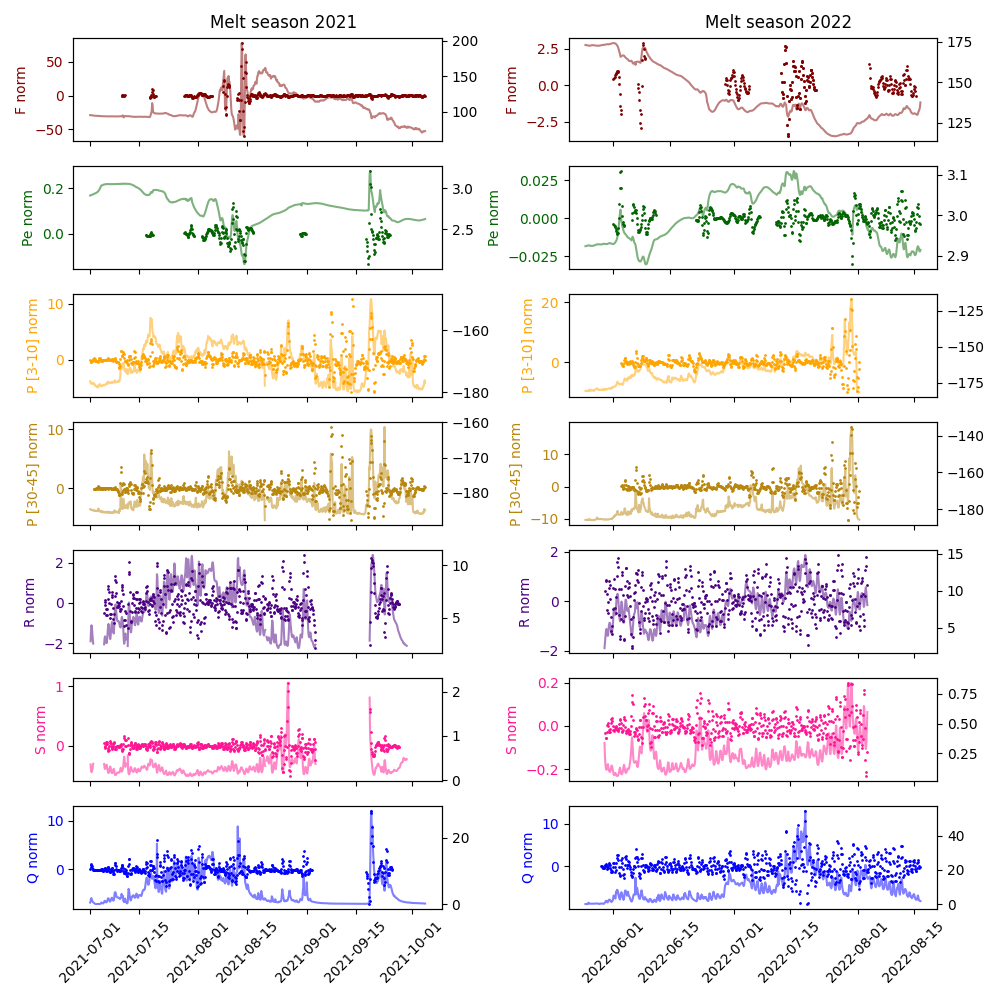

In [41]:
color = ['maroon', 'darkgreen', 'orange', 'darkgoldenrod', 'indigo', 'deeppink', 'b',]
label = ['F (N)', 'Pe (MPa)', 'P [3-10] (dB)', 'P [30-45 Hz] (dB)', 'R/R$_{ref}$', 'S/S$_{ref}$', 'Q (m$^3$.s$^{-1}$)']

fig, axs = plt.subplots(7, 2, figsize=(10,10), sharex='col')
axs[0][0].scatter(df_filter_diurnal_L_melt_2021['TIMESTAMP'][idx_L], df_filter_diurnal_L_melt_2021['L'][idx_L], color='maroon', marker='o', s=1)
axs[0][0].set_ylabel('F norm', color='maroon')
axs[0][0].tick_params(axis='y', labelcolor='maroon')
axs[0][0].tick_params(axis='x', rotation=45)
ax1=axs[0][0].twinx()
ax1.plot(df_melt_2021['TIMESTAMP'], df_melt_2021['L'], color='maroon', alpha=0.5)

axs[1][0].scatter(df_filter_diurnal_Pe_melt_2021['TIMESTAMP'][idx_Pe], df_filter_diurnal_Pe_melt_2021['Pe'][idx_Pe], color='darkgreen', marker='o', s=1)
axs[1][0].set_ylabel('Pe norm', color='darkgreen')
axs[1][0].tick_params(axis='y', labelcolor='darkgreen')
axs[1][0].tick_params(axis='x', rotation=45)
ax2=axs[1][0].twinx()
ax2.plot(df_melt_2021['TIMESTAMP'], df_melt_2021['Pe'], 'darkgreen', alpha=0.5)

axs[2][0].scatter(df_filter_diurnal_P3_10_melt_2021['TIMESTAMP'], df_filter_diurnal_P3_10_melt_2021['P3_10'], color='orange', marker='o', s=1)
axs[2][0].set_ylabel('P [3-10] norm', color='orange')
axs[2][0].tick_params(axis='y', labelcolor='orange')
axs[2][0].tick_params(axis='x', rotation=45)
ax3=axs[2][0].twinx()
ax3.plot(df_melt_2021['TIMESTAMP'], df_melt_2021['P3_10'], 'orange', alpha=0.5)

axs[3][0].scatter(df_filter_diurnal_P30_45_melt_2021['TIMESTAMP'][idx_P], df_filter_diurnal_P30_45_melt_2021['P30_45'][idx_P], color='darkgoldenrod', marker='o', s=1)
axs[3][0].set_ylabel('P [30-45] norm', color='darkgoldenrod')
axs[3][0].tick_params(axis='y', labelcolor='darkgoldenrod')
axs[3][0].tick_params(axis='x', rotation=45)
ax4=axs[3][0].twinx()
ax4.plot(df_melt_2021['TIMESTAMP'], df_melt_2021['P30_45'], 'darkgoldenrod', alpha=0.5)

axs[4][0].scatter(df_filter_diurnal_R_melt_2021['TIMESTAMP'][idx_S], df_filter_diurnal_R_melt_2021['R'][idx_S], color='indigo', marker='o', s=1)
axs[4][0].set_ylabel('R norm', color='indigo')
axs[4][0].tick_params(axis='y', labelcolor='indigo')
axs[4][0].tick_params(axis='x', rotation=45)
ax4=axs[4][0].twinx()
ax4.plot(df_melt_2021['TIMESTAMP'], df_melt_2021['R'], 'indigo', alpha=0.5)

axs[5][0].scatter(df_filter_diurnal_S_melt_2021['TIMESTAMP'][idx_S], df_filter_diurnal_S_melt_2021['S'][idx_S], color='deeppink', marker='o', s=1)
axs[5][0].set_ylabel('S norm', color='deeppink')
axs[5][0].tick_params(axis='y', labelcolor='deeppink')
axs[5][0].tick_params(axis='x', rotation=45)
ax4=axs[5][0].twinx()
ax4.plot(df_melt_2021['TIMESTAMP'], df_melt_2021['S'], 'deeppink', alpha=0.5)


axs[6][0].scatter(df_filter_diurnal_Runoff_melt_2021['TIMESTAMP'][idx_Q], df_filter_diurnal_Runoff_melt_2021['Runoff'][idx_Q], color='b', marker='o', s=1)
axs[6][0].set_ylabel('Q norm', color='b')
axs[6][0].tick_params(axis='y', labelcolor='b')
axs[6][0].tick_params(axis='x', rotation=45)
ax7=axs[6][0].twinx()
ax7.plot(df_melt_2021['TIMESTAMP'], df_melt_2021['Runoff'], 'b', alpha=0.5)

# #------------------------------------------------------------------------------------------------------------------------------------

axs[0][1].scatter(df_filter_diurnal_L_melt_2022['TIMESTAMP'][idx_L_22], df_filter_diurnal_L_melt_2022['L'][idx_L_22], color='maroon', marker='o', s=1)
axs[0][1].set_ylabel('F norm', color='maroon')
axs[0][1].tick_params(axis='y', labelcolor='maroon')
axs[0][1].tick_params(axis='x', rotation=45)
ax1=axs[0][1].twinx()
ax1.plot(df_melt_2022['TIMESTAMP'], df_melt_2022['L'], color='maroon', alpha=0.5)

axs[1][1].scatter(df_filter_diurnal_Pe_melt_2022['TIMESTAMP'][idx_Pe_22], df_filter_diurnal_Pe_melt_2022['Pe'][idx_Pe_22], color='darkgreen', marker='o', s=1)
axs[1][1].set_ylabel('Pe norm', color='darkgreen')
axs[1][1].tick_params(axis='y', labelcolor='darkgreen')
axs[1][1].tick_params(axis='x', rotation=45)
ax2=axs[1][1].twinx()
ax2.plot(df_melt_2022['TIMESTAMP'], df_melt_2022['Pe'], 'darkgreen', alpha=0.5)

axs[2][1].scatter(df_filter_diurnal_P3_10_melt_2022['TIMESTAMP'][idx_P310_22], df_filter_diurnal_P3_10_melt_2022['P3_10'][idx_P310_22], color='orange', marker='o', s=1)
axs[2][1].set_ylabel('P [3-10] norm', color='orange')
axs[2][1].tick_params(axis='y', labelcolor='orange')
axs[2][1].tick_params(axis='x', rotation=45)
ax3=axs[2][1].twinx()
ax3.plot(df_melt_2022['TIMESTAMP'], df_melt_2022['P3_10'], 'orange', alpha=0.5)

axs[3][1].scatter(df_filter_diurnal_P30_45_melt_2022['TIMESTAMP'][idx_P3045_22], df_filter_diurnal_P30_45_melt_2022['P30_45'][idx_P3045_22], color='darkgoldenrod', marker='o', s=1)
axs[3][1].set_ylabel('P [30-45] norm', color='darkgoldenrod')
axs[3][1].tick_params(axis='y', labelcolor='darkgoldenrod')
axs[3][1].tick_params(axis='x', rotation=45)
ax4=axs[3][1].twinx()
ax4.plot(df_melt_2022['TIMESTAMP'], df_melt_2022['P30_45'], 'darkgoldenrod', alpha=0.5)

axs[4][1].scatter(df_filter_diurnal_R_melt_2022['TIMESTAMP'][idx_R_22], df_filter_diurnal_R_melt_2022['R'][idx_R_22], color='indigo', marker='o', s=1)
axs[4][1].set_ylabel('R norm', color='indigo')
axs[4][1].tick_params(axis='y', labelcolor='indigo')
axs[4][1].tick_params(axis='x', rotation=45)
ax4=axs[4][1].twinx()
ax4.plot(df_melt_2022['TIMESTAMP'], df_melt_2022['R'], 'indigo', alpha=0.5)

axs[5][1].scatter(df_filter_diurnal_S_melt_2022['TIMESTAMP'][idx_S_22], df_filter_diurnal_S_melt_2022['S'][idx_S_22], color='deeppink', marker='o', s=1)
axs[5][1].set_ylabel('S norm', color='deeppink')
axs[5][1].tick_params(axis='y', labelcolor='deeppink')
axs[5][1].tick_params(axis='x', rotation=45)
ax4=axs[5][1].twinx()
ax4.plot(df_melt_2022['TIMESTAMP'], df_melt_2022['S'], 'deeppink', alpha=0.5)

axs[6][1].scatter(df_filter_diurnal_Runoff_melt_2022['TIMESTAMP'][idx_Q_22], df_filter_diurnal_Runoff_melt_2022['Runoff'][idx_Q_22], color='b', marker='o', s=1)
axs[6][1].set_ylabel('Q norm', color='b')
axs[6][1].tick_params(axis='y', labelcolor='b')
axs[6][1].tick_params(axis='x', rotation=45)
ax7=axs[6][1].twinx()
ax7.plot(df_melt_2022['TIMESTAMP'], df_melt_2022['Runoff'], 'b', alpha=0.5)

axs[0][0].text(0.37, 1.1, 'Melt season 2021', 
    color='k', 
    fontsize=12, 
    transform=axs[0][0].transAxes)

axs[0][1].text(0.37, 1.1, 'Melt season 2022', 
    color='k', 
    fontsize=12, 
    transform=axs[0][1].transAxes)

plt.tight_layout()
plt.savefig(path_fig_export+'bandpass_diurnal_filtered.pdf', bbox_inches='tight')

## Compare prediction to data at the diurnal time scale

In [42]:
P_Q_1=[]
P_Q_2=[]
R=[]
S_Q_1=[]
S_Q_2=[]
shift=[]
Q_P =[]



for i in np.arange(0.1, 100, 0.1):
    # print('la')
    P_Q_1.append(1.25*np.log(i))
    P_Q_2.append(14/3*np.log(i))
    # R.append(np.log(i)**(9/22))
    R.append(i**(9/22))
    S_Q_1.append(i**(-2/11))
    S_Q_2.append(i**2)
    
        
    # R.append((9/22*np.log(i)))
    # S_Q_1.append(i**(-2/11))
    # S_Q_2.append(i**2)

In [43]:
curve_prop_P_diurnal=pd.DataFrame({'Q':np.arange(0.1, 100, 0.1), 'P_5/4_Q':P_Q_1, 'P_14/3_Q':P_Q_2,
                          'R_Q':R, 'S_2/11_Q':S_Q_1, 'S_2_Q':S_Q_2})

In [44]:
df_filter_diurnal_P3_10_melt_2021['P3_10 trend']=df_filter_diurnal_P3_10_melt_2021['P3_10']+df_melt_2021['P3_10'].mean()
df_filter_diurnal_Runoff_melt_2021['Runoff trend']=df_filter_diurnal_Runoff_melt_2021['Runoff']+df_melt_2021['Runoff'].mean()
df_filter_diurnal_R_melt_2021['R trend']=df_filter_diurnal_R_melt_2021['R']+df_melt_2021['R'].mean()
df_filter_diurnal_S_melt_2021['S trend']=df_filter_diurnal_S_melt_2021['S']+df_melt_2021['S'].mean()

df_filter_diurnal_P3_10_melt_2022['P3_10 trend']=df_filter_diurnal_P3_10_melt_2022['P3_10']+df_melt_2022['P3_10'].mean()
df_filter_diurnal_Runoff_melt_2022['Runoff trend']=df_filter_diurnal_Runoff_melt_2022['Runoff']+df_melt_2022['Runoff'].mean()
df_filter_diurnal_R_melt_2022['R trend']=df_filter_diurnal_R_melt_2022['R']+df_melt_2022['R'].mean()
df_filter_diurnal_S_melt_2022['S trend']=df_filter_diurnal_S_melt_2022['S']+df_melt_2022['S'].mean()

P_ref_diurnal=df_filter_diurnal_P3_10_melt_2021['P3_10 trend'][0]
Q_ref_diurnal=df_filter_diurnal_Runoff_melt_2021['Runoff trend'][0]

In [45]:
idx_Q_L21 = np.sort(list(set(idx_Q.tolist()) & set(idx_L.tolist())))
idx_Q_Pe21 = np.sort(list(set(idx_Q.tolist()) & set(idx_Pe.tolist())))
idx_Q_P21 = np.sort(list(set(idx_Q.tolist()) & set(idx_P.tolist())))
idx_Q_R21 = np.sort(list(set(idx_Q.tolist()) & set(idx_R.tolist())))
idx_Q_S21 = np.sort(list(set(idx_Q.tolist()) & set(idx_S.tolist())))

In [46]:
idx_Q_L22 = np.sort(list(set(idx_Q_22.tolist()) & set(idx_L_22.tolist())))
idx_Q_Pe22 = np.sort(list(set(idx_Q_22.tolist()) & set(idx_Pe_22.tolist())))
idx_Q_P22 = np.sort(list(set(idx_Q_22.tolist()) & set(idx_P310_22.tolist())))
idx_Q_R22 = np.sort(list(set(idx_Q_22.tolist()) & set(idx_R_22.tolist())))
idx_Q_S22 = np.sort(list(set(idx_Q_22.tolist()) & set(idx_S_22.tolist())))

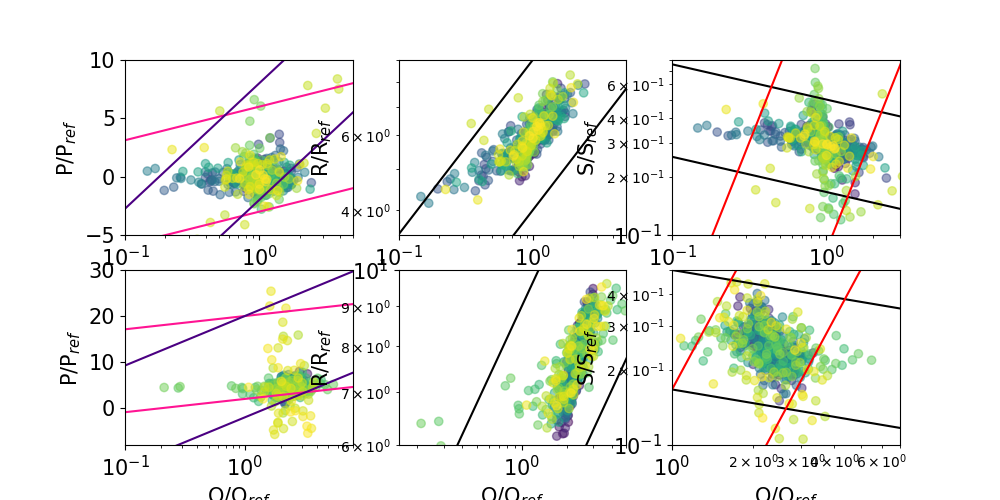

In [66]:
fig, axs = plt.subplots(2, 3, figsize=(10,5))
# axs[0][0].scatter(df_filter_3D_Runoff_melt_2021['Runoff'][idx_Q_P21]-df_filter_3D_Runoff_melt_2021['Runoff'][idx_Q_P21].min()
#                   , df_filter_3D_P3_10_melt_2021['P3_10'][idx_Q_P21]-df_filter_3D_P3_10_melt_2021['P3_10'][idx_Q_P21].min()
#                   , c=range(len(idx_Q_P21)), marker='o')
axs[0][0].scatter(df_filter_diurnal_Runoff_melt_2021['Runoff trend'][idx_Q_P21]/Q_ref_diurnal
                  , (df_filter_diurnal_P3_10_melt_2021['P3_10 trend'][idx_Q_P21])-P_ref_diurnal
                  , c=range(len(idx_Q_P21)), marker='o', alpha=0.5)
axs[0][0].set_xlabel('Q/', fontsize=15)
axs[0][0].set_ylabel('P/P$_{ref}$', fontsize=15)
axs[0][0].set_xscale('log')
axs[0][0].tick_params(labelsize=15)
axs[0][0].plot(curve_prop_P_diurnal['Q'], curve_prop_P_diurnal['P_5/4_Q']-3, 'deeppink')
axs[0][0].plot(curve_prop_P_diurnal['Q'], curve_prop_P_diurnal['P_5/4_Q']+6, 'deeppink')

axs[0][0].plot(curve_prop_P_diurnal['Q'], curve_prop_P_diurnal['P_14/3_Q']+8, 'indigo')
axs[0][0].plot(curve_prop_P_diurnal['Q'], curve_prop_P_diurnal['P_14/3_Q']-2, 'indigo')

axs[0][0].set_ylim([-5, 10])
axs[0][0].set_xlim([0.1, 5])

axs[0][1].scatter(df_filter_diurnal_Runoff_melt_2021['Runoff trend'][idx_Q_R21]/Q_ref_diurnal, df_filter_diurnal_R_melt_2021['R trend'][idx_Q_R21], c=range(len(idx_Q_R21)), marker='o', alpha=0.5)
axs[0][1].set_xlabel('Q', fontsize=15)
axs[0][1].set_ylabel('R/R$_{ref}$', fontsize=15)
axs[0][1].tick_params(labelsize=15)
axs[0][1].plot(curve_prop_P_diurnal['Q'], curve_prop_P_diurnal['R_Q']*4, 'k')
axs[0][1].plot(curve_prop_P_diurnal['Q'], curve_prop_P_diurnal['R_Q']*9, 'k')

axs[0][1].set_xlim([0.1, 5])
axs[0][1].set_ylim([3.5, 9])
axs[0][1].set_xscale('log')
axs[0][1].set_yscale('log')

axs[0][2].scatter(df_filter_diurnal_Runoff_melt_2021['Runoff trend'][idx_Q_S21]/Q_ref_diurnal, df_filter_diurnal_S_melt_2021['S trend'][idx_Q_S21], c=range(len(idx_Q_S21)), marker='o', alpha=0.5)
axs[0][2].set_xlabel('Q', fontsize=15)
axs[0][2].set_ylabel('S/S$_{ref}$', fontsize=15)
axs[0][2].tick_params(labelsize=15)
axs[0][2].plot(curve_prop_P_diurnal['Q'], curve_prop_P_diurnal['S_2/11_Q']/6, 'k')
axs[0][2].plot(curve_prop_P_diurnal['Q'], curve_prop_P_diurnal['S_2/11_Q']/2, 'k')

axs[0][2].plot(curve_prop_P_diurnal['Q'], curve_prop_P_diurnal['S_2_Q']*3, 'r')
axs[0][2].plot(curve_prop_P_diurnal['Q'], curve_prop_P_diurnal['S_2_Q']/12, 'r')

axs[0][2].set_xlim([0.1, 3])
axs[0][2].set_ylim([0.1, 0.8])
axs[0][2].set_xscale('log')
axs[0][2].set_yscale('log')
# # #-------------------------------------------------------------------------------------------------------------------------------------
axs[1][0].scatter(df_filter_diurnal_Runoff_melt_2022['Runoff trend'][idx_Q_P22]/Q_ref_diurnal
                  , (df_filter_diurnal_P3_10_melt_2022['P3_10 trend'][idx_Q_P22])-P_ref_diurnal
                  , c=range(len(idx_Q_P22)), marker='o', alpha=0.5)
axs[1][0].set_xlabel('Q/Q$_{ref}$', fontsize=15)
axs[1][0].set_ylabel('P/P$_{ref}$', fontsize=15)
axs[1][0].tick_params(labelsize=15)
axs[1][0].plot(curve_prop_P_diurnal['Q'], curve_prop_P_diurnal['P_5/4_Q']+2, 'deeppink')
axs[1][0].plot(curve_prop_P_diurnal['Q'], curve_prop_P_diurnal['P_5/4_Q']+20, 'deeppink')

axs[1][0].plot(curve_prop_P_diurnal['Q'], curve_prop_P_diurnal['P_14/3_Q']+20, 'indigo')
axs[1][0].plot(curve_prop_P_diurnal['Q'], curve_prop_P_diurnal['P_14/3_Q']-2, 'indigo')

# axs[1][0].set_yscale('log')
axs[1][0].set_xscale('log')
axs[1][0].set_ylim([-8, 30])
axs[1][0].set_xlim([0.1, 8])

axs[1][1].scatter(df_filter_diurnal_Runoff_melt_2022['Runoff trend'][idx_Q_R22]/Q_ref_diurnal, df_filter_diurnal_R_melt_2022['R trend'][idx_Q_R22], c=range(len(idx_Q_R22)), marker='o', alpha=0.5)
axs[1][1].set_xlabel('Q/Q$_{ref}$', fontsize=15)
axs[1][1].set_ylabel('R/R$_{ref}$', fontsize=15)
axs[1][1].tick_params(labelsize=15)
axs[1][1].plot(curve_prop_P_diurnal['Q'], curve_prop_P_diurnal['R_Q']*9, 'k')
axs[1][1].plot(curve_prop_P_diurnal['Q'], curve_prop_P_diurnal['R_Q']*4, 'k')

axs[1][1].set_yscale('log')
axs[1][1].set_xscale('log')
axs[1][1].set_xlim([0.15, 5])
axs[1][1].set_ylim([6, 10])

axs[1][2].scatter(df_filter_diurnal_Runoff_melt_2022['Runoff trend'][idx_Q_S22]/Q_ref_diurnal, df_filter_diurnal_S_melt_2022['S trend'][idx_Q_S22], c=range(len(idx_Q_S22)), marker='o', alpha=0.5)
# axs[1][2].plot(df_filter_diurnal_Runoff_melt_2022['Runoff trend'][idx_Q_S22]/Q_ref_diurnal, df_filter_diurnal_S_melt_2022['S trend'][idx_Q_S22])
axs[1][2].set_xlabel('Q/Q$_{ref}$', fontsize=15)
axs[1][2].set_ylabel('S/S$_{ref}$', fontsize=15)
axs[1][2].tick_params(labelsize=15)
axs[1][2].plot(curve_prop_P_diurnal['Q'], curve_prop_P_diurnal['S_2/11_Q']/6, 'k')
axs[1][2].plot(curve_prop_P_diurnal['Q'], curve_prop_P_diurnal['S_2/11_Q']/2, 'k')

axs[1][2].plot(curve_prop_P_diurnal['Q'], curve_prop_P_diurnal['S_2_Q']/6, 'r')
axs[1][2].plot(curve_prop_P_diurnal['Q'], curve_prop_P_diurnal['S_2_Q']/50, 'r')

axs[1][2].set_xscale('log')
axs[1][2].set_yscale('log')
axs[1][2].set_xlim([1, 7])
axs[1][2].set_ylim([0.1, 0.5])
plt.savefig(path_fig_export+'hysteresis_diurnal.svg', bbox_inches='tight')


In [49]:
df_filter_diurnal_Runoff_melt_2022

TIMESTAMP    Runoff  Runoff trend
0   2022-05-25 00:00:00  0.000488      9.702384
1   2022-05-25 03:00:00 -0.051613      9.650283
2   2022-05-25 06:00:00 -0.105849      9.596047
3   2022-05-25 09:00:00 -0.144647      9.557250
4   2022-05-25 12:00:00 -0.041213      9.660683
..                  ...       ...           ...
665 2022-08-16 03:00:00  1.113114     10.815010
666 2022-08-16 06:00:00  0.148811      9.850708
667 2022-08-16 09:00:00 -0.285930      9.415966
668 2022-08-16 12:00:00 -0.256182      9.445714
669 2022-08-16 15:00:00 -0.048556      9.653340

[670 rows x 3 columns]

In [57]:
5/4*np.log(df_filter_diurnal_Runoff_melt_2022['Runoff trend']/Q_ref_diurnal)

0      1.065881
1      1.059150
2      1.052105
3      1.047041
4      1.060497
         ...   
665    1.201585
666    1.084846
667    1.028425
668    1.032368
669    1.059546
Name: Runoff trend, Length: 670, dtype: float64

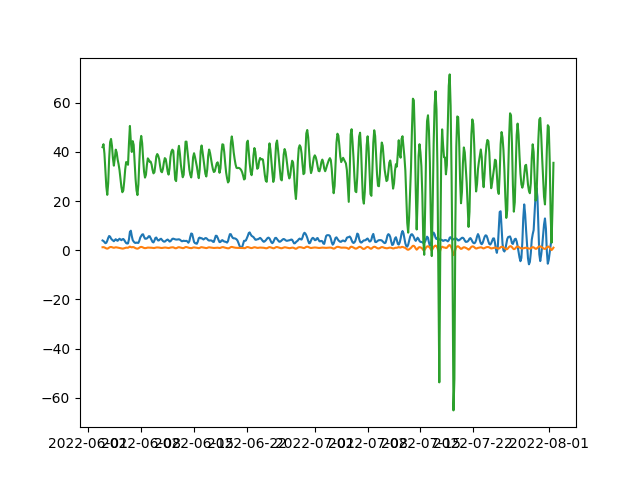

In [60]:
fig, ax =plt.subplots()
ax.plot(df_filter_diurnal_Runoff_melt_2022['TIMESTAMP'][idx_Q_P22], df_filter_diurnal_P3_10_melt_2022['P3_10 trend'][idx_Q_P22]-P_ref_diurnal)
ax.plot(df_filter_diurnal_Runoff_melt_2022['TIMESTAMP'][idx_Q_P22], 5/4*np.log(df_filter_diurnal_Runoff_melt_2022['Runoff trend'][idx_Q_P22]/Q_ref_diurnal))
ax.plot(df_filter_diurnal_Runoff_melt_2022['TIMESTAMP'][idx_Q_P22], 14*3*np.log(df_filter_diurnal_Runoff_melt_2022['Runoff trend'][idx_Q_P22]/Q_ref_diurnal))


## Redefine dataframe

In [49]:
# df_filter_3D_L_melt_2021 = df_filter_3D_L_melt_2021.loc[idx_L]
# df_filter_3D_L_melt_2022 = df_filter_3D_L_melt_2022.loc[idx_L_22]

# df_filter_3D_Pe_melt_2021 = df_filter_3D_Pe_melt_2021.loc[idx_Pe]
# df_filter_3D_Pe_melt_2022 = df_filter_3D_Pe_melt_2022.loc[idx_Pe_22]

# df_filter_3D_P3_10_melt_2021 = pd.DataFrame({'TIMESTAMP':df_filter_3D_P3_10_melt_2021['TIMESTAMP'], 'P3_10':filterbandpass_P3_10_3D_melt_2021})
# df_filter_3D_P3_10_melt_2022 = pd.DataFrame({'TIMESTAMP':df_filter_3D_P3_10_melt_2022['TIMESTAMP'][idx_P310_22], 'P3_10':filterbandpass_P3_10_3D_melt_2022[idx_P310_22]})

# df_filter_3D_P30_45_melt_2021 = pd.DataFrame({'TIMESTAMP':df_filter_3D_P30_45_melt_2021['TIMESTAMP'][idx_P], 'P3_10':filterbandpass_P30_45_3D_melt_2021[idx_P]})
# df_filter_3D_P30_45_melt_2022 = pd.DataFrame({'TIMESTAMP':df_filter_3D_P30_45_melt_2022['TIMESTAMP'][idx_P3045_22], 'P30_45':filterbandpass_P30_45_3D_melt_2022[idx_P3045_22]})

# df_filter_3D_R_melt_2021 = df_filter_3D_R_melt_2021.loc[idx_R_S]
# df_filter_3D_R_melt_2022 = df_filter_3D_R_melt_2022.loc[idx_R_S_22]

# df_filter_3D_S_melt_2021 = df_filter_3D_S_melt_2021.loc[idx_R_S]
# df_filter_3D_S_melt_2022 = df_filter_3D_S_melt_2022.loc[idx_R_S_22]

# df_filter_3D_Runoff_melt_2021 = df_filter_3D_Runoff_melt_2021.loc[idx_Q]
# df_filter_3D_Runoff_melt_2022 = df_filter_3D_Runoff_melt_2022.loc[idx_Q_22]

## Derive derivatives and select index to find cycles to find the cycles according to Runoff variations

In [50]:
# original value filter (61,8)
for d in np.arange(0, len(df)):
    df_temp = df[d]
    # globals()[f'filterbandpass_Runoff_smooth_{name[d]}'] = scipy.signal.savgol_filter(globals()[f'df_filter_diurnal_Runoff_{name[d]}']['Runoff'],
    #                                                                                  11,
    #                                                                                  2)
    globals()[f'filterbandpass_Runoff_smooth_{name[d]}'] = globals()[f'df_filter_diurnal_Runoff_{name[d]}']['Runoff']
    globals()[f'filterbandpass_Runoff_1der_{name[d]}'] = np.gradient(globals()[f'filterbandpass_Runoff_smooth_{name[d]}'])
    
    globals()[f'filterbandpass_Runoff_01_{name[d]}']=[]
    
    for j in np.arange(0, globals()[f'filterbandpass_Runoff_1der_{name[d]}'].shape[0]):
        
        if globals()[f'filterbandpass_Runoff_1der_{name[d]}'][j]>0:
            globals()[f'filterbandpass_Runoff_01_{name[d]}'].append(1)
        else:
            globals()[f'filterbandpass_Runoff_01_{name[d]}'].append(-1)
            
    globals()[f'filterbandpass_Runoff_2der_{name[d]}'] = np.gradient(globals()[f'filterbandpass_Runoff_01_{name[d]}'])
    globals()[f'ii_down_Runoff_diurnal_{name[d]}'] = np.where(globals()[f'filterbandpass_Runoff_2der_{name[d]}']==-1)[0][0::2] #To take only one element out of 2
    globals()[f'ii_up_Runoff_diurnal_{name[d]}'] = np.where(globals()[f'filterbandpass_Runoff_2der_{name[d]}']==1)[0][0::2]

In [51]:
filterbandpass_Runoff_2der_melt_2021

array([ 0.,  0., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
        0.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.,  1.,  1.,  0., -1.,
       -1.,  0.,  0.,  1.,  1.,  0.,  0., -1., -1.,  0.,  0.,  1.,  1.,
        0.,  0., -1., -1.,  0.,  0.,  1.,  1.,  0.,  0., -1., -1.,  0.,
        0.,  1.,  1.,  0.,  0., -1., -1.,  0.,  0.,  0.,  1.,  1., -1.,
       -1.,  0.,  1.,  1.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.,  1.,
        1.,  0., -1., -1.,  0.,  0.,  1.,  1.,  0.,  0., -1., -1.,  0.,
        0.,  1.,  1.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0.,  1.,  1.,
        0.,  0., -1., -1.,  0.,  1.,  1.,  0., -1., -1.,  0.,  0.,  0.,
        1.,  1.,  0., -1., -1.,  0.,  0.,  1.,  1.,  0.,  0.,  0., -1.,
       -1.,  0.,  0.,  1.,  1.,  0.,  0.,  0., -1., -1.,  0.,  1.,  1.,
        0., -1., -1.,  0.,  0.,  0.,  1.,  1.,  0., -1., -1.,  0.,  0.,
        1.,  1.,  0.,  0., -1., -1.,  0.,  0.,  1.,  1.,  0.,  0., -1.,
       -1.,  0.,  0.,  0.,  1.,  1.,  0., -1., -1.,  0.,  0.,  1

In [52]:
ii_up_Runoff_diurnal_melt_2021

array([ 11,  22,  29,  37,  45,  53,  62,  67,  77,  84,  92, 102, 109,
       117, 124, 133, 141, 149, 156, 164, 173, 180, 188, 196, 204, 213,
       221, 228, 236, 245, 252, 260, 266, 276, 284, 292, 297, 301, 309,
       317, 325, 333, 341, 348, 356, 365, 370, 374, 382, 389, 397, 406,
       414, 421, 436, 445, 451, 461, 469, 477, 484, 492, 499, 506, 523,
       529, 536, 541, 545, 552, 558, 566, 574, 579, 586, 593, 603, 610,
       640, 652, 669, 674, 683, 694, 704, 708, 713, 721, 726, 731, 737,
       750, 756, 760, 765])

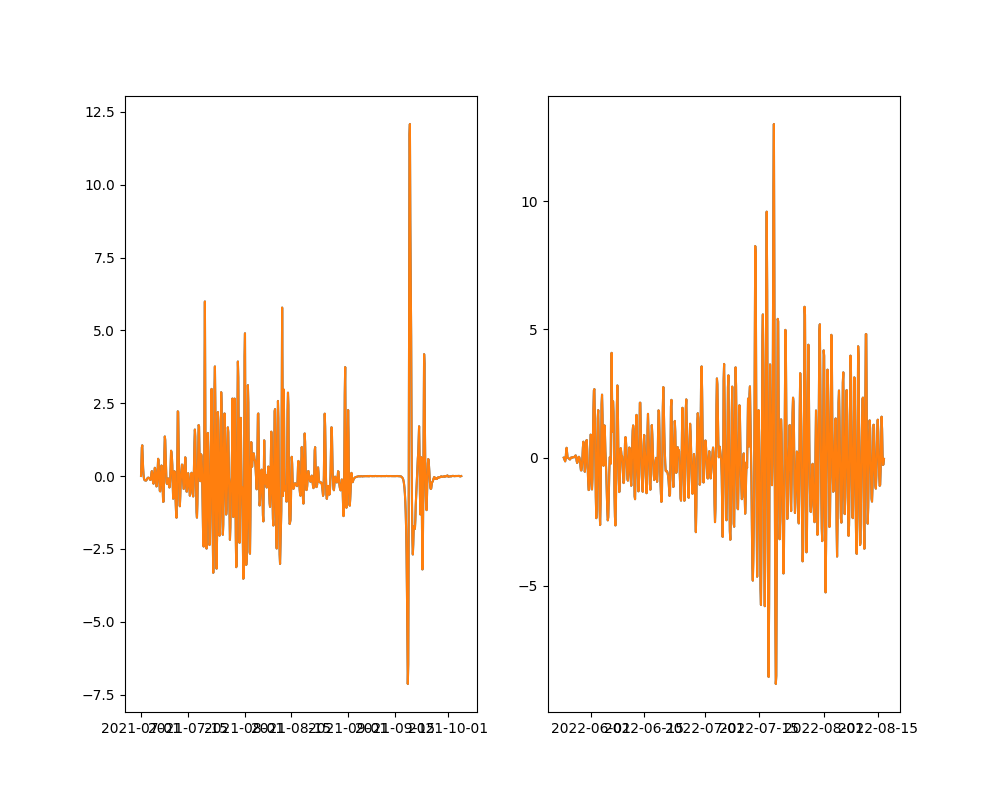

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
ax1.plot(df_filter_diurnal_Runoff_melt_2021['TIMESTAMP'], df_filter_diurnal_Runoff_melt_2021['Runoff'])
ax1.plot(df_filter_diurnal_Runoff_melt_2021['TIMESTAMP'], filterbandpass_Runoff_smooth_melt_2021)

ax2.plot(df_filter_diurnal_Runoff_melt_2022['TIMESTAMP'], df_filter_diurnal_Runoff_melt_2022['Runoff'])
ax2.plot(df_filter_diurnal_Runoff_melt_2022['TIMESTAMP'], filterbandpass_Runoff_smooth_melt_2022)

In [54]:
df_filter_diurnal_Runoff_melt_2021.iloc[767]

TIMESTAMP       2021-10-04 21:00:00
Runoff                    -0.000067
Runoff trend               4.131892
Name: 767, dtype: object

In [55]:
for d in np.arange(0, len(df)):
    df_temp = df[d]
    df_temp.reset_index(inplace=True)
    globals()[f'index_Runoff_diurnal_{name[d]}'] = []
    
    globals()[f'ii_up_Runoff_diurnal_{name[d]}'] = np.insert(globals()[f'ii_up_Runoff_diurnal_{name[d]}'], 0, 0)
    globals()[f'index_Runoff_diurnal_{name[d]}'] = np.append(globals()[f'ii_up_Runoff_diurnal_{name[d]}'], globals()[f'df_filter_diurnal_Runoff_{name[d]}'].shape[0]-1)
    
    
    
    # if globals()[f'ii_down_Runoff_3D_{name[d]}'][0] > globals()[f'ii_up_Runoff_3D_{name[d]}'][0]:
    #     globals()[f'i_up_Runoff_3D_{name[d]}'] = np.append(globals()[f'ii_up_Runoff_3D_{name[d]}'], df_temp.index[-1])
    #     globals()[f'index_Runoff_3D_{name[d]}'] = np.insert(globals()[f'i_up_Runoff_3D_{name[d]}'], 0, 0)
    # else:
    #     globals()[f'i_down_Runoff_3D_{name[d]}'] = np.append(globals()[f'ii_down_Runoff_3D_{name[d]}'], df_temp.index[-1])
    #     globals()[f'index_Runoff_3D_{name[d]}'] = np.insert(globals()[f'i_down_Runoff_3D_{name[d]}'], 0, 0)


In [56]:
# for i in index_Runoff_3D_melt_2021.tolist():
#     time_event_2021=[]
#     y_2021 = []
#     time_event_2021.append(df_filter_3D_Runoff_melt_2021['TIMESTAMP'][i])
#     y_2021.append(0)

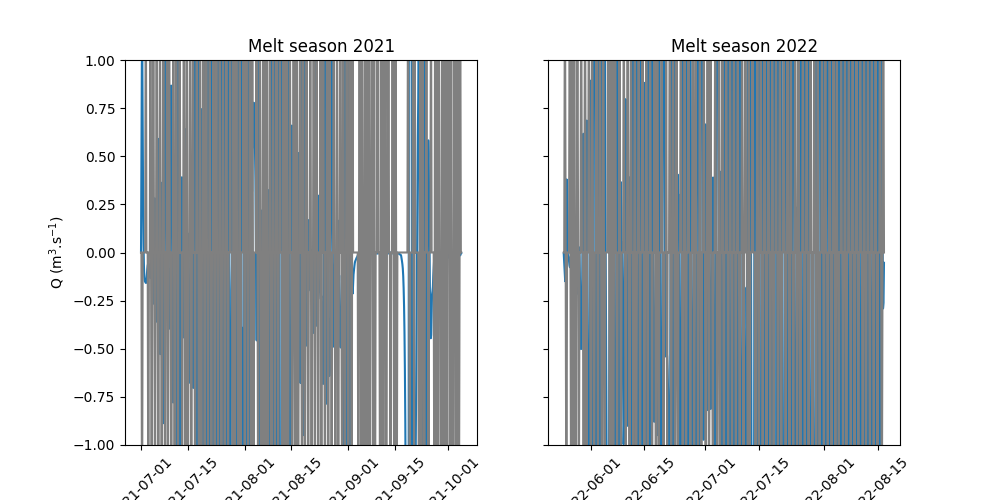

In [57]:
# %matplotlib widget
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)
axs[0].plot(df_filter_diurnal_Runoff_melt_2021['TIMESTAMP'], 
            df_filter_diurnal_Runoff_melt_2021['Runoff']-df_filter_diurnal_Runoff_melt_2021['Runoff'].mean())
axs[0].plot(df_filter_diurnal_Runoff_melt_2021['TIMESTAMP'],filterbandpass_Runoff_2der_melt_2021, 'grey')
axs[0].tick_params('x', rotation=45)
axs[0].set_ylabel('Q (m$^3$.s$^{-1}$)')
axs[0].set_ylim([-1, 1])


axs[1].plot(df_filter_diurnal_Runoff_melt_2022['TIMESTAMP'],
            df_filter_diurnal_Runoff_melt_2022['Runoff']-df_filter_diurnal_Runoff_melt_2022['Runoff'].mean())
axs[1].plot(df_filter_diurnal_Runoff_melt_2022['TIMESTAMP'],filterbandpass_Runoff_2der_melt_2022, 'grey')
axs[1].tick_params('x', rotation=45)
axs[1].set_ylim([-1, 1])


axs[0].text(0.35, 1.02, 'Melt season 2021', 
    color='k', 
    fontsize=12, 
    transform=axs[0].transAxes)
axs[1].text(0.35, 1.02, 'Melt season 2022', 
    color='k', 
    fontsize=12, 
    transform=axs[1].transAxes)

plt.savefig(path_fig_export+'event_runoff.pdf', bbox_inches='tight')

In [58]:
df_filter_diurnal_Runoff_melt_2021

TIMESTAMP    Runoff  Runoff trend
0   2021-07-01 00:00:00  0.003783      4.135742
1   2021-07-01 03:00:00  0.481416      4.613375
2   2021-07-01 06:00:00  0.981582      5.113541
3   2021-07-01 09:00:00  1.057068      5.189028
4   2021-07-01 12:00:00  0.681920      4.813879
..                  ...       ...           ...
763 2021-10-04 09:00:00 -0.004571      4.127388
764 2021-10-04 12:00:00 -0.012408      4.119552
765 2021-10-04 15:00:00 -0.009892      4.122067
766 2021-10-04 18:00:00 -0.003183      4.128776
767 2021-10-04 21:00:00 -0.000067      4.131892

[768 rows x 3 columns]

In [59]:
filterbandpass_Runoff_2der_melt_2021

array([ 0.,  0., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
        0.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.,  1.,  1.,  0., -1.,
       -1.,  0.,  0.,  1.,  1.,  0.,  0., -1., -1.,  0.,  0.,  1.,  1.,
        0.,  0., -1., -1.,  0.,  0.,  1.,  1.,  0.,  0., -1., -1.,  0.,
        0.,  1.,  1.,  0.,  0., -1., -1.,  0.,  0.,  0.,  1.,  1., -1.,
       -1.,  0.,  1.,  1.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.,  1.,
        1.,  0., -1., -1.,  0.,  0.,  1.,  1.,  0.,  0., -1., -1.,  0.,
        0.,  1.,  1.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0.,  1.,  1.,
        0.,  0., -1., -1.,  0.,  1.,  1.,  0., -1., -1.,  0.,  0.,  0.,
        1.,  1.,  0., -1., -1.,  0.,  0.,  1.,  1.,  0.,  0.,  0., -1.,
       -1.,  0.,  0.,  1.,  1.,  0.,  0.,  0., -1., -1.,  0.,  1.,  1.,
        0., -1., -1.,  0.,  0.,  0.,  1.,  1.,  0., -1., -1.,  0.,  0.,
        1.,  1.,  0.,  0., -1., -1.,  0.,  0.,  1.,  1.,  0.,  0., -1.,
       -1.,  0.,  0.,  0.,  1.,  1.,  0., -1., -1.,  0.,  0.,  1

# Create a dataframe to save every event

## Create a dataframe to save time of every event

In [60]:
df_melt_2021

index     Time           TIMESTAMP          L        Pe       P3_10  \
0      128   16.000 2021-07-01 00:00:00  95.343681  2.910845 -176.429602   
1      129   16.125 2021-07-01 03:00:00  95.327061  2.913258 -176.929432   
2      130   16.250 2021-07-01 06:00:00  95.255476  2.915607 -177.186138   
3      131   16.375 2021-07-01 09:00:00  95.201321  2.917524 -176.918924   
4      132   16.500 2021-07-01 12:00:00  95.146242  2.919731 -177.006568   
..     ...      ...                 ...        ...       ...         ...   
763    891  111.375 2021-10-04 09:00:00  72.668144  2.618755 -177.875939   
764    892  111.500 2021-10-04 12:00:00  72.848286  2.620269 -177.888632   
765    893  111.625 2021-10-04 15:00:00  72.622734  2.621790 -176.810488   
766    894  111.750 2021-10-04 18:00:00  72.511203  2.623406 -176.106772   
767    895  111.875 2021-10-04 21:00:00  72.865749  2.625247 -176.933639   

         P30_45         R         S    Runoff  
0   -184.669361       NaN       NaN  0.449876  
1   -184.786684  2.780367  0.355130  0.821738  
2   -184.835858  3.746705  0.223936  1.682886  
3   -184.832795  4.296542  0.179636  1.770574  
4   -184.806039  4.080946  0.191817  1.233248  
..          ...       ...       ...       ...  
763 -185.376275       NaN       NaN  0.173252  
764 -185.594885       NaN       NaN  0.157165  
765 -184.604488       NaN       NaN  0.154683  
766 -185.045972       NaN       NaN  0.158233  
767 -185.020343       NaN       NaN  0.151036  

[768 rows x 10 columns]

In [61]:
index_Runoff_diurnal_melt_2021

array([  0,  11,  22,  29,  37,  45,  53,  62,  67,  77,  84,  92, 102,
       109, 117, 124, 133, 141, 149, 156, 164, 173, 180, 188, 196, 204,
       213, 221, 228, 236, 245, 252, 260, 266, 276, 284, 292, 297, 301,
       309, 317, 325, 333, 341, 348, 356, 365, 370, 374, 382, 389, 397,
       406, 414, 421, 436, 445, 451, 461, 469, 477, 484, 492, 499, 506,
       523, 529, 536, 541, 545, 552, 558, 566, 574, 579, 586, 593, 603,
       610, 640, 652, 669, 674, 683, 694, 704, 708, 713, 721, 726, 731,
       737, 750, 756, 760, 765, 767])

In [62]:
df=[df_melt_2021, df_melt_2022]
for d in np.arange(0, len(name)):
    df_temp=df[d]
    # df_temp.set_index('index', inplace=True)
    dt=[]
    start=[]
    stop=[]

    for i in np.arange(0, len(globals()[f'index_Runoff_diurnal_{name[d]}'])-1):
        # print(globals()[f'index_Runoff_diurnal_{name[d]}'][i+1])
        start.append(df_temp['TIMESTAMP'][globals()[f'index_Runoff_diurnal_{name[d]}'][i]])
        stop.append(df_temp['TIMESTAMP'][globals()[f'index_Runoff_diurnal_{name[d]}'][i+1]])
        dt.append(df_temp['TIMESTAMP'][globals()[f'index_Runoff_diurnal_{name[d]}'][i+1]]-
                  df_temp['TIMESTAMP'][globals()[f'index_Runoff_diurnal_{name[d]}'][i]])

    globals()[f'df_event_time_{name[d]}']=pd.DataFrame({'Event': np.arange(0,len(globals()[f'index_Runoff_diurnal_{name[d]}'])-1),'Start':start, 'Stop':stop, 'Duration':dt})

In [63]:
for d in np.arange(0, len(name)):
    globals()[f'df_event_time_{name[d]}'].to_csv(path_df_export+f'/Event_diurnal/{name[d]}/df_event_time_{name[d]}.csv')

# Calculate metrics for every events

## Coeff variations

In [64]:
for d in np.arange(0, len(name)):
    
    for j in np.arange(3, len(df_melt_2021.columns)):
        
        df_temp=globals()[f'df_filter_diurnal_{df_melt_2021.columns[j]}_{name[d]}']
        globals()[f'cv_{df_temp.columns[1]}_{name[d]}']=[]
            
        for i in np.arange(0, len(globals()[f'index_Runoff_diurnal_{name[d]}'])-1):

            idx1 = globals()[f'index_Runoff_diurnal_{name[d]}'][i]
            idx2 = globals()[f'index_Runoff_diurnal_{name[d]}'][i+1]

            std = np.std(df_temp[df_temp.columns[1]][idx1:idx2])
            mean = np.mean(df_temp[df_temp.columns[1]][idx1:idx2])
            
            globals()[f'cv_{df_temp.columns[1]}_{name[d]}'].append(std/mean)
            

## Uniform length of event and normalise data to calculate hysteresis

In [65]:
for d in np.arange(0, len(df)):
    for j in np.arange(3, len(df_melt_2021.columns)):
        globals()[f'df_filter_diurnal_{df_melt_2021.columns[j]}_{name[d]}'].reset_index(inplace=True)

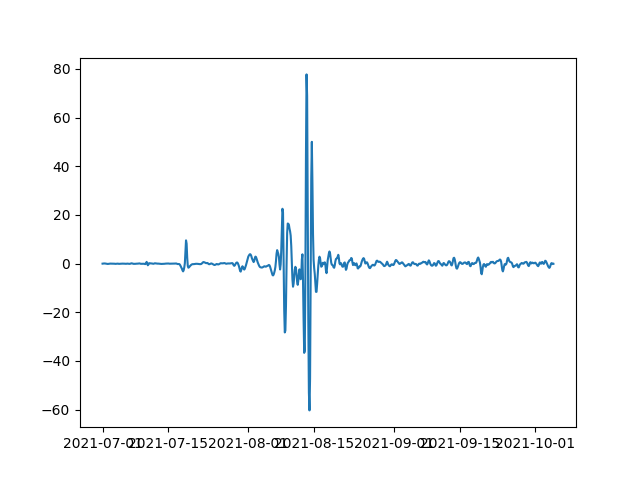

In [66]:
fig, ax = plt.subplots()
ax.plot(df_filter_diurnal_L_melt_2021['TIMESTAMP'], df_filter_diurnal_L_melt_2021['L'])

### Uniform length

In [67]:
f = int(np.ceil(10))
a=f -1 if f % 2 == 0 else f
a

9

In [68]:
df=[df_melt_2021, df_melt_2022]
x_int=50

for d in np.arange(0, len(df)):
    df_temp = df[d]
    
    for j in np.arange(3, len(df_temp.columns)):
        df_temp_diurnal_runoff=globals()[f'df_filter_diurnal_Runoff_{name[d]}']
        df_temp_diurnal=globals()[f'df_filter_diurnal_{df_temp.columns[j]}_{name[d]}']
        
        # df_temp_3D_runoff.reset_index(inplace=True)
        # df_temp_3D.reset_index(inplace=True)

        
        for i in np.arange(0, len(globals()[f'index_Runoff_diurnal_{name[d]}'])-1):
            idx1=globals()[f'index_Runoff_diurnal_{name[d]}'][i]
            idx2=globals()[f'index_Runoff_diurnal_{name[d]}'][i+1]
            
            globals()[f'event_Runoff_{name[d]}_{i}']=[]
            globals()[f'event_{df_temp_diurnal.columns[2]}_{name[d]}_{i}']=[]
            
            globals()[f'event_Runoff_{name[d]}_orig_{i}']=[]
            globals()[f'event_{df_temp_diurnal.columns[2]}_{name[d]}_orig_{i}']=[]
            
            # print(idx1, idx2)
            # print(df_temp_3D.columns[2])

            x=np.arange(idx1, idx2)
            y=df_temp_diurnal_runoff['Runoff'][idx1:idx2]
            y2=df_temp_diurnal[df_temp_diurnal.columns[2]][idx1:idx2]
            # f=sp.interp1d(x, y, kind='cubic', fill_value='extrapolate')
            f = signal.resample(y, x_int)
            # print(len(y2))
            if len(y2)!=0:
                f2= signal.resample(y2, x_int)
            else:
                f2=np.nan
            # print(len(y), len(y2))
            # print(len(y), len(y2))

            
            if len(y)== len(y2):
                
                window=len(f) -1 if len(f) % 2 == 0 else len(f)
                window2=len(f2) -1 if len(f) % 2 == 0 else len(f2)
                
                
                
                globals()[f'event_Runoff_{name[d]}_orig_{i}'].append(y)
                globals()[f'event_{df_temp_diurnal.columns[2]}_{name[d]}_orig_{i}'].append(y2)

                globals()[f'event_Runoff_{name[d]}_{i}'].append(scipy.signal.savgol_filter(f, window, 6))
                globals()[f'event_{df_temp_diurnal.columns[2]}_{name[d]}_{i}'].append(scipy.signal.savgol_filter(f2, window2, 6))
            
            # globals()[f'df_event_{name[d]}_{i}']=pd.DataFrame({'Runoff':globals()[f'event_Runoff_{name[d]}_{i}'][0]})
#             var = pd.DataFrame({str(df_temp_3D.columns[2]):globals()[f'event_{df_temp_3D.columns[2]}_{name[d]}_{i}']})
            
#             globals()[f'df_event_{name[d]}_{i}'] = pd.concat([globals()[f'df_event_{name[d]}_{i}'], var], axis=1)
            
            

In [69]:
# fig, axs = plt.subplots(1, 2)
# L=scipy.signal.savgol_filter(event_R_melt_2022_5[0], 15, 2)
# Runoff=scipy.signal.savgol_filter(event_Runoff_melt_2022_5[0], 15, 2)

# print(len(L))
# print(len(Runoff))

# ax.plot(np.arange(0, len(event_L_melt_2022_orig_10[0])), event_Runoff_melt_2022_orig_10[0], 'r')
# axs[0].plot(np.arange(0, len(event_Pe_melt_2022_15[0])), event_Runoff_melt_2022_15[0], 'k')
# ax1=axs[0].twinx()
# ax1.plot(np.arange(0, len(event_Pe_melt_2022_15[0])), event_Pe_melt_2022_15[0], 'r')

# axs[1].plot(np.arange(0, len(event_Pe_melt_2022_orig_15[0])), event_Runoff_melt_2022_orig_15[0], 'k')
# ax1=axs[1].twinx()
# ax1.plot(np.arange(0, len(event_Pe_melt_2022_orig_15[0])), event_Pe_melt_2022_orig_15[0], 'r')
# plt.tight_layout()

In [70]:
df=[df_melt_2021, df_melt_2022]

for d in np.arange(0, len(df)):
    df_temp = df[d]
    
    for i in np.arange(0, len(globals()[f'index_Runoff_diurnal_{name[d]}'])-1):
        # globals()[f'df_event_{name[d]}_{i}']=pd.DataFrame({'Runoff':globals()[f'event_Runoff_{name[d]}_{i}'][0]})
        globals()[f'df_event_{name[d]}_{i}']=pd.DataFrame()
        
        for j in np.arange(3, len(df_temp.columns)):
            # print(i, df_temp.columns[j])
            
                # print(i, df_temp.columns[j])
            if len(globals()[f'event_{df_temp.columns[j]}_{name[d]}_{i}'])>0:
                l=globals()[f'event_{df_temp.columns[j]}_{name[d]}_{i}'][0]
                var = pd.DataFrame({str(df_temp.columns[j]):pd.Series(l)})
                globals()[f'df_event_{name[d]}_{i}']=pd.concat([globals()[f'df_event_{name[d]}_{i}'],var], axis=1)
            else:
                n=pd.DataFrame({str(df_temp.columns[j]):np.repeat(np.nan, len(globals()[f'index_Runoff_diurnal_{name[d]}'])-1)})
                
                # print(n)
                globals()[f'df_event_{name[d]}_{i}']=pd.concat([globals()[f'df_event_{name[d]}_{i}'],n], axis=1)

### Normalise data

In [71]:
# df_event_melt_2021_13

In [72]:
for d in np.arange(0, len(df)):
    
    for i in np.arange(0, len(globals()[f'index_Runoff_diurnal_{name[d]}'])-1):
        df_temp = globals()[f'df_event_{name[d]}_{i}']
        
        globals()[f'df_event_{name[d]}_norm_{i}']=pd.DataFrame()
        
        for k in np.arange(0, len(df_temp.columns)):
            globals()[f'event_{df_temp.columns[k]}_{name[d]}_norm_{i}']=[]
            
            for j in np.arange(0,x_int):
                # print(i, df_temp.columns[k], j)
                # print(df_temp[df_temp.columns[k]])
                globals()[f'event_{df_temp.columns[k]}_{name[d]}_norm_{i}'].append((df_temp[df_temp.columns[k]][j]
                                                                                    -np.nanmin(df_temp[df_temp.columns[k]]))
                                                                                    /(np.nanmax(df_temp[df_temp.columns[k]])
                                                                                    -np.nanmin(df_temp[df_temp.columns[k]])))
            # print(globals()[f'event_{df_temp.columns[k]}_{name[d]}_norm_{i}'])
            var = pd.DataFrame({str(df_temp.columns[k]):pd.Series(globals()[f'event_{df_temp.columns[k]}_{name[d]}_norm_{i}'])})
            # print(var)
            globals()[f'df_event_{name[d]}_norm_{i}']=pd.concat([globals()[f'df_event_{name[d]}_norm_{i}'], var], axis=1)
            globals()[f'df_event_{name[d]}_norm_{i}'].to_csv(path_df_export+f'Event_diurnal/{name[d]}/normalise_length/df_event_{name[d]}_norm_{i}.csv')

<ipython-input-72-df0aedb74dc5>:15: RuntimeWarning: All-NaN axis encountered
  -np.nanmin(df_temp[df_temp.columns[k]]))
<ipython-input-72-df0aedb74dc5>:16: RuntimeWarning: All-NaN axis encountered
  /(np.nanmax(df_temp[df_temp.columns[k]])
<ipython-input-72-df0aedb74dc5>:17: RuntimeWarning: All-NaN axis encountered
  -np.nanmin(df_temp[df_temp.columns[k]])))


## Calculate hysteresis

In [73]:
# df_event_melt_2022_norm_26=df_event_melt_2022_norm_26.replace('NaN', np.nan)

In [74]:
for d in np.arange(0, len(df)):
    
    for j in np.arange(0, len(df_temp.columns)-1):
        globals()[f'theta_{name[d]}_{df_temp.columns[j]}']=[]

        for i in np.arange(0, len(globals()[f'index_Runoff_diurnal_{name[d]}'])-1):
        # for i in np.arange(0, 1):
            # print(i)
            df_temp = globals()[f'df_event_{name[d]}_norm_{i}']


            max_x_r=df_temp['Runoff'].idxmax()
            max_x_v=df_temp.shape[0]
            

            if max_x_r is np.nan:
                
                globals()[f'theta_{name[d]}_{df_temp.columns[j]}'].append(np.nan)

            else:
                sample2=df_temp[df_temp.columns[j]][max_x_r:max_x_v]
                
                if max_x_r!=0:
                    sample1=df_temp[df_temp.columns[j]][0:max_x_r]
                    rising=np.nanmean(sample1)
                    falling=np.nanmean(sample2)

                else:
                    rising=df_temp[df_temp.columns[j]][0]
                    falling=np.nanmean(sample2)
            
                globals()[f'theta_{name[d]}_{df_temp.columns[j]}'].append((rising-falling)/falling)

<ipython-input-74-2541b6f2ff80>:25: RuntimeWarning: Mean of empty slice
  rising=np.nanmean(sample1)
<ipython-input-74-2541b6f2ff80>:26: RuntimeWarning: Mean of empty slice
  falling=np.nanmean(sample2)
<ipython-input-74-2541b6f2ff80>:30: RuntimeWarning: Mean of empty slice
  falling=np.nanmean(sample2)


In [75]:
theta_melt_2021_L

[0.8090450941564165,
 0.5735237663434279,
 1.7245047432076426,
 -0.3618770515805282,
 -0.3252906407891807,
 -0.24971164147190245,
 -0.6874354842006489,
 1.8972230509306505,
 -0.6587215483711217,
 -0.25898587787460353,
 -0.6316072470864069,
 2.4397879143288264,
 -0.6613344208443377,
 3.89162100420848,
 -0.34423919464878244,
 0.8981412201125244,
 -0.6603811909377957,
 8.238681696195654,
 -0.34126820844622996,
 0.01514625280051243,
 -0.8626335345501773,
 1.351943336921362,
 -0.5225159746749137,
 -0.7226021730602543,
 -0.6718573958809455,
 2.00956580279281,
 -0.6894520274080782,
 -0.20215985033961903,
 2.1173054479844167,
 0.13180515539664162,
 -0.4302510668551355,
 0.918006788328535,
 1.5510756139985906,
 0.5853500784832004,
 -0.7718067322219506,
 2.2092008551787905,
 -0.5376500221561391,
 1.381010566597172,
 -0.7587096258535606,
 -0.8728082626779051,
 1.546329690672205,
 0.4726876467866739,
 -0.6554170225108858,
 -0.5814997546510898,
 -0.04932889713609221,
 1.4855113693210806,
 -0.196354

# Create dataframe metrics

In [76]:
df_melt_2021

index     Time           TIMESTAMP          L        Pe       P3_10  \
0      128   16.000 2021-07-01 00:00:00  95.343681  2.910845 -176.429602   
1      129   16.125 2021-07-01 03:00:00  95.327061  2.913258 -176.929432   
2      130   16.250 2021-07-01 06:00:00  95.255476  2.915607 -177.186138   
3      131   16.375 2021-07-01 09:00:00  95.201321  2.917524 -176.918924   
4      132   16.500 2021-07-01 12:00:00  95.146242  2.919731 -177.006568   
..     ...      ...                 ...        ...       ...         ...   
763    891  111.375 2021-10-04 09:00:00  72.668144  2.618755 -177.875939   
764    892  111.500 2021-10-04 12:00:00  72.848286  2.620269 -177.888632   
765    893  111.625 2021-10-04 15:00:00  72.622734  2.621790 -176.810488   
766    894  111.750 2021-10-04 18:00:00  72.511203  2.623406 -176.106772   
767    895  111.875 2021-10-04 21:00:00  72.865749  2.625247 -176.933639   

         P30_45         R         S    Runoff  
0   -184.669361       NaN       NaN  0.449876  
1   -184.786684  2.780367  0.355130  0.821738  
2   -184.835858  3.746705  0.223936  1.682886  
3   -184.832795  4.296542  0.179636  1.770574  
4   -184.806039  4.080946  0.191817  1.233248  
..          ...       ...       ...       ...  
763 -185.376275       NaN       NaN  0.173252  
764 -185.594885       NaN       NaN  0.157165  
765 -184.604488       NaN       NaN  0.154683  
766 -185.045972       NaN       NaN  0.158233  
767 -185.020343       NaN       NaN  0.151036  

[768 rows x 10 columns]

In [77]:
for d in np.arange(0, len(df)):
    len(theta_melt_2021_L)
    
    globals()[f'df_cv_{name[d]}']=pd.DataFrame({'Event':np.arange(0, len(globals()[f'theta_{name[d]}_L']))})
    globals()[f'df_theta_{name[d]}']=pd.DataFrame({'Event':np.arange(0, len(globals()[f'theta_{name[d]}_L']))})

    df_temp=df[d]
    for j in np.arange(3, len(df_temp.columns)-1):
        
        cv = globals()[f'cv_{df_temp.columns[j]}_{name[d]}']
        df_cv = pd.DataFrame({str(df_temp.columns[j]):cv})
        
        theta = globals()[f'theta_{name[d]}_{df_temp.columns[j]}']
        
        df_theta = pd.DataFrame({str(df_temp.columns[j]):theta})
        
        
        globals()[f'df_cv_{name[d]}']=pd.concat([globals()[f'df_cv_{name[d]}'], df_cv], axis=1)
        globals()[f'df_theta_{name[d]}']=pd.concat([globals()[f'df_theta_{name[d]}'], df_theta], axis=1)
    
    theta = globals()[f'df_theta_{name[d]}'][['L', 'Pe', 'P3_10', 'P30_45','R', 'S']]
    globals()[f'df_metrics_{name[d]}']=pd.concat([globals()[f'df_cv_{name[d]}'], theta], axis=1)
    
    globals()[f'df_cv_{name[d]}'].to_csv(path_df_export+f'/Event_diurnal/{name[d]}/df_event_cv_{name[d]}.csv')
    globals()[f'df_theta_{name[d]}'].to_csv(path_df_export+f'/Event_diurnal/{name[d]}/df_event_theta_{name[d]}.csv')
    globals()[f'df_metrics_{name[d]}'].to_csv(path_df_export+f'/Event_diurnal/{name[d]}/df_event_metrics_{name[d]}.csv')

In [78]:
df_metrics_melt_2021

Event          L        Pe      P3_10    P30_45         R         S  \
0       0  -4.287675 -0.978651  -3.531680 -0.629168  1.390666 -1.353936   
1       1   4.626221 -0.409425  -1.443997  4.894521       NaN       NaN   
2       2  -1.868959  0.789127 -14.821106 -1.532903       NaN       NaN   
3       3  -2.368372  0.248178  -0.841785 -1.332516 -1.477023  5.964922   
4       4  -1.233805  1.044387   1.015972  6.792122  5.625867 -5.653771   
..    ...        ...       ...        ...       ...       ...       ...   
91     91 -11.474611 -1.201757  -6.467152 -4.380589       NaN       NaN   
92     92   0.842452 -0.223091  -1.758357 -3.440790       NaN       NaN   
93     93  -0.687936 -0.236309  -0.414485 -0.206285       NaN       NaN   
94     94  -1.109461 -0.271716  -0.695737 -0.815894       NaN       NaN   
95     95  -1.137897 -0.170783   0.117609  0.138039       NaN       NaN   

           L        Pe     P3_10    P30_45         R         S  
0   0.809045  0.965298 -0.728686 -0.345971       NaN       NaN  
1   0.573524  1.903340 -0.611400 -0.720924       NaN       NaN  
2   1.724505 -0.200150  0.577439 -0.385058       NaN       NaN  
3  -0.361877  1.182852  0.025912  0.438799       NaN       NaN  
4  -0.325291  1.963556  0.547552  0.093056 -0.495854  1.289986  
..       ...       ...       ...       ...       ...       ...  
91 -0.424360  2.445707 -0.250626 -0.286377       NaN       NaN  
92  0.114877  1.686359  0.644477  0.074363       NaN       NaN  
93  1.469153 -0.693000  0.948595  1.211330       NaN       NaN  
94 -0.780704 -0.709668 -0.781354 -0.813059       NaN       NaN  
95  0.083332 -0.076683 -0.076683  0.083332       NaN       NaN  

[96 rows x 13 columns]

## Normalise CV and theta to compare them

In [79]:
np.max(df_theta_melt_2021['L'][np.isfinite(df_theta_melt_2021['L'])])

8.238681696195654

In [80]:
for d in np.arange(0, len(df)):
    df_temp_cv=globals()[f'df_cv_{name[d]}']
    df_temp_theta=globals()[f'df_theta_{name[d]}']
    
    globals()[f'df_theta_norm_{name[d]}']=pd.DataFrame()
    globals()[f'df_cv_norm_{name[d]}']=pd.DataFrame()
    
    for j in np.arange(1, len(df_temp_theta.columns)):
        globals()[f'theta_{df_temp_theta.columns[j]}_{name[d]}_norm']=[]
        globals()[f'cv_{df_temp_cv.columns[j]}_{name[d]}_norm']=[]
        
        for i in np.arange(0, df_temp_theta.shape[0]):
            globals()[f'theta_{df_temp_theta.columns[j]}_{name[d]}_norm'].append(df_temp_theta[df_temp_theta.columns[j]][i]
                                                              /df_temp_theta[df_temp_theta.columns[j]]
                                                                                 [np.isfinite(df_temp_theta[df_temp_theta.columns[j]])].max())
            # print(globals()[f'theta_{df_temp_theta.columns[j]}_{name[d]}_norm']-df_temp_theta[df_temp_theta.columns[j]])
            globals()[f'cv_{df_temp_cv.columns[j]}_{name[d]}_norm'].append((df_temp_cv[df_temp_cv.columns[j]][i]-df_temp_cv[df_temp_cv.columns[j]]
                                                                                 [np.isfinite(df_temp_cv[df_temp_cv.columns[j]])].min())
                                                              /(df_temp_cv[df_temp_cv.columns[j]]
                                                                                 [np.isfinite(df_temp_cv[df_temp_cv.columns[j]])].max()-
                                                                df_temp_cv[df_temp_cv.columns[j]]
                                                                                 [np.isfinite(df_temp_cv[df_temp_cv.columns[j]])].min()))
        # print(globals()[f'theta_{df_temp_theta.columns[j]}_{name[d]}_norm'])
        # t = pd.Series(globals()[f'theta_{df_temp_theta.columns[j]}_{name[d]}_norm'])
        theta = pd.DataFrame({str(df_temp_theta.columns[j]):globals()[f'theta_{df_temp_theta.columns[j]}_{name[d]}_norm']})
        cv = pd.DataFrame({str(df_temp_cv.columns[j]):globals()[f'cv_{df_temp_cv.columns[j]}_{name[d]}_norm']})
        
        globals()[f'df_theta_norm_{name[d]}']=pd.concat([globals()[f'df_theta_norm_{name[d]}'], theta], axis=1)
        globals()[f'df_cv_norm_{name[d]}']=pd.concat([globals()[f'df_cv_norm_{name[d]}'], cv], axis=1)
    
    theta_norm = globals()[f'df_theta_norm_{name[d]}'][['L', 'Pe', 'P3_10', 'P30_45',
       'R', 'S']]
    globals()[f'df_metrics_norm_{name[d]}']=pd.concat([globals()[f'df_cv_norm_{name[d]}'], theta_norm], axis=1)
    
    globals()[f'df_cv_norm_{name[d]}'].to_csv(path_df_export+f'/Event_diurnal/{name[d]}/df_event_cv_norm_{name[d]}.csv')
    globals()[f'df_theta_norm_{name[d]}'].to_csv(path_df_export+f'/Event_diurnal/{name[d]}/df_event_theta_norm_{name[d]}.csv')
    globals()[f'df_metrics_norm_{name[d]}'].to_csv(path_df_export+f'/Event_diurnal/{name[d]}/df_event_metrics_norm_{name[d]}.csv')

In [81]:
df_theta_norm_melt_2021

L        Pe     P3_10    P30_45         R         S
0   0.098201  0.206370 -0.081613 -0.098381       NaN       NaN
1   0.069614  0.406913 -0.068477 -0.205004       NaN       NaN
2   0.209318 -0.042790  0.064674 -0.109496       NaN       NaN
3  -0.043924  0.252880  0.002902  0.124778       NaN       NaN
4  -0.039483  0.419786  0.061326  0.026462 -0.317818  0.105876
..       ...       ...       ...       ...       ...       ...
91 -0.051508  0.522865 -0.028070 -0.081435       NaN       NaN
92  0.013944  0.360525  0.072182  0.021146       NaN       NaN
93  0.178324 -0.148156  0.106243  0.344456       NaN       NaN
94 -0.094761 -0.151719 -0.087512 -0.231203       NaN       NaN
95  0.010115 -0.016394 -0.008589  0.023697       NaN       NaN

[96 rows x 6 columns]

In [82]:
for d in np.arange(0, len(df)):
    
    globals()[f'df_theta_norm_{name[d]}'].index = globals()[f'df_event_time_{name[d]}']['Start'] 
    globals()[f'df_cv_norm_{name[d]}'].index = globals()[f'df_event_time_{name[d]}']['Start'] 


In [83]:
for d in np.arange(0, len(df)):
    globals()[f'df_theta_norm_{name[d]}'].index=globals()[f'df_theta_norm_{name[d]}'].index.format(formatter=lambda x: x.strftime('%d-%m-%Y'))
    globals()[f'df_cv_norm_{name[d]}'].index=globals()[f'df_cv_norm_{name[d]}'].index.format(formatter=lambda x: x.strftime('%d-%m-%Y'))


In [84]:
df_theta_melt_2021

Event         L        Pe     P3_10    P30_45         R         S
0       0  0.809045  0.965298 -0.728686 -0.345971       NaN       NaN
1       1  0.573524  1.903340 -0.611400 -0.720924       NaN       NaN
2       2  1.724505 -0.200150  0.577439 -0.385058       NaN       NaN
3       3 -0.361877  1.182852  0.025912  0.438799       NaN       NaN
4       4 -0.325291  1.963556  0.547552  0.093056 -0.495854  1.289986
..    ...       ...       ...       ...       ...       ...       ...
91     91 -0.424360  2.445707 -0.250626 -0.286377       NaN       NaN
92     92  0.114877  1.686359  0.644477  0.074363       NaN       NaN
93     93  1.469153 -0.693000  0.948595  1.211330       NaN       NaN
94     94 -0.780704 -0.709668 -0.781354 -0.813059       NaN       NaN
95     95  0.083332 -0.076683 -0.076683  0.083332       NaN       NaN

[96 rows x 7 columns]

# Plot event/ hysteresis with metrics

In [85]:
df_theta_melt_2021

Event         L        Pe     P3_10    P30_45         R         S
0       0  0.809045  0.965298 -0.728686 -0.345971       NaN       NaN
1       1  0.573524  1.903340 -0.611400 -0.720924       NaN       NaN
2       2  1.724505 -0.200150  0.577439 -0.385058       NaN       NaN
3       3 -0.361877  1.182852  0.025912  0.438799       NaN       NaN
4       4 -0.325291  1.963556  0.547552  0.093056 -0.495854  1.289986
..    ...       ...       ...       ...       ...       ...       ...
91     91 -0.424360  2.445707 -0.250626 -0.286377       NaN       NaN
92     92  0.114877  1.686359  0.644477  0.074363       NaN       NaN
93     93  1.469153 -0.693000  0.948595  1.211330       NaN       NaN
94     94 -0.780704 -0.709668 -0.781354 -0.813059       NaN       NaN
95     95  0.083332 -0.076683 -0.076683  0.083332       NaN       NaN

[96 rows x 7 columns]

In [86]:
path_df_export

'/home/colili/Documents/PhD/ploughmeter_project/processing_2122/Dataframe_produced/Dataframe_clean/diurnal/'

# Plot every event

In [87]:
color = ['maroon', 'darkgreen', 'orange', 'darkgoldenrod', 'indigo', 'deeppink', 'b',]
label = ['L (N)', 'Pe (MPa)', 'P [3-10] (dB)', 'P [30-45 Hz] (dB)', 'R/R$_{ref}$', 'S/S$_{ref}$', 'Q (m$^3$.s$^{-1}$)']
for d in np.arange(0, len(df)):
    globals()[f'df_sum_{name[d]}']=pd.DataFrame()
    globals()[f'df_slope_{name[d]}']=pd.DataFrame()

    
    
    for i in np.arange(0, len(globals()[f'index_Runoff_diurnal_{name[d]}'])-1):
    # for i in np.arange(0, 1):
        fig, axs = plt.subplots(2, 6, figsize=(20,4), sharey=True)
        
        df_temp_theta = globals()[f'df_theta_{name[d]}']
        df_temp_cv = globals()[f'df_cv_{name[d]}']
        
        globals()[f's_{i}']=pd.DataFrame()
        globals()[f'm_{i}']=pd.DataFrame()

        
        for j in np.arange(1, len(df_temp_theta.columns)):
            # print(j, df_temp_theta.columns[j])
            df_event=globals()[f'df_event_{name[d]}_norm_{i}']
            
            axs[0][j-1].plot(np.arange(0, x_int), df_event['Runoff'], color='b')
            axs[0][j-1].set_ylabel('Runoff')
            ax1=axs[0][j-1].twinx()
            ax1.plot(np.arange(0, x_int), df_event[str(df_temp_theta.columns[j])], color=color[j-1])
            axs[0][j-1].set_ylabel(str(df_temp_theta.columns[j]))
            
            theta = round(df_temp_theta[str(df_temp_theta.columns[j])][i], 2)
            cv = round(df_temp_cv[str(df_temp_cv.columns[j])][i], 4)
            area=round(np.sum(df_event[str(df_temp_theta.columns[j])]-df_event['Runoff']), 2)
            
            axs[0][j-1].text(0.35, 1.1, f'Theta:{theta}, CV:{cv}', color='k', transform=axs[0][j-1].transAxes)
            
            p, res, _, _, _=np.polyfit(df_event['Runoff'], df_event[str(df_temp_theta.columns[j])], 1, full=True)
            
            s, inter = np.poly1d(np.polyfit(df_event['Runoff'], df_event[str(df_temp_theta.columns[j])], 1))
            axs[1][j-1].scatter(df_event['Runoff'], df_event[str(df_temp_theta.columns[j])], cmap='viridis', c=range(x_int))
            axs[1][j-1].plot(np.unique(df_event['Runoff']), 
                             np.poly1d(np.polyfit(df_event['Runoff'],
                                                  df_event[str(df_temp_theta.columns[j])], 1))(np.unique(df_event['Runoff'])), 'k')
            axs[1][j-1].set_xlabel('Runoff')
            axs[1][j-1].set_ylabel(str(df_temp_theta.columns[j]))
            axs[1][j-1].text(0.35, 1.1, f'Slope:{round(s, 2)}, Sum:{round(res[0], 2)}', color='k', transform=axs[1][j-1].transAxes)
            
            # print(s)
            s_temp = pd.DataFrame({str(df_temp_theta.columns[j]):round(res[0], 2)}, index=[i])
            slope_temp=pd.DataFrame({str(df_temp_theta.columns[j]):round(s, 2)}, index=[i])
            globals()[f's_{i}']=pd.concat([globals()[f's_{i}'], s_temp], axis=1)
            globals()[f'm_{i}']=pd.concat([globals()[f'm_{i}'], slope_temp], axis=1)

        
        globals()[f'df_sum_{name[d]}']=pd.concat([globals()[f'df_sum_{name[d]}'], globals()[f's_{i}']])
        globals()[f'df_sum_{name[d]}'].to_csv(path_df_export+f'Event_diurnal/{name[d]}/df_sum_{name[d]}.csv')
        
        globals()[f'df_slope_{name[d]}']=pd.concat([globals()[f'df_slope_{name[d]}'], globals()[f'm_{i}']])
        globals()[f'df_slope_{name[d]}'].to_csv(path_df_export+f'Event_diurnal/{name[d]}/df_slope_{name[d]}.csv')
        
        plt.tight_layout()    
        plt.savefig(path_fig_export+f'event_diurnal/{name[d]}/event_{i}.pdf', bbox_inches='tight')
        plt.close()

In [88]:
# df_sum_melt_2022

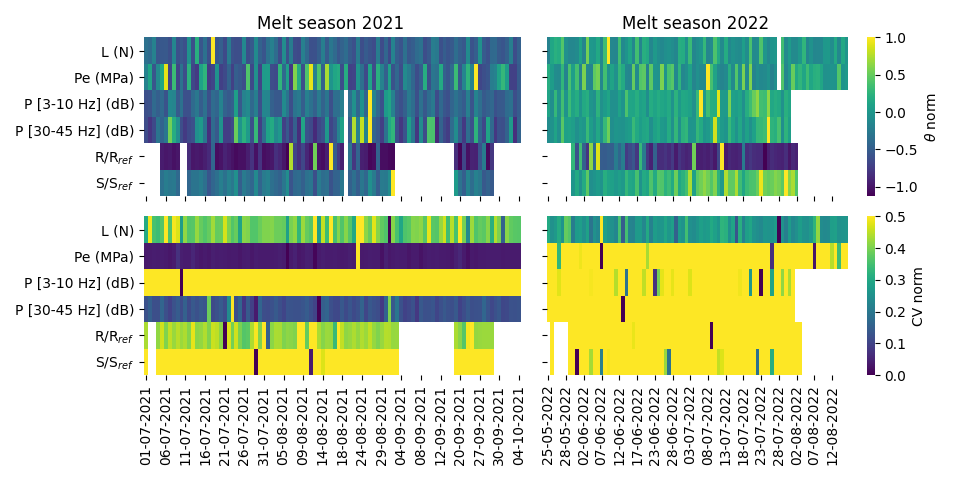

In [89]:
w, h = figaspect(.5)
fig, axs = plt.subplots(2, 2, figsize=(w, h), sharey=True)
y_axis_labels = ['L (N)', 'Pe (MPa)', 'P [3-10 Hz] (dB)', 'P [30-45 Hz] (dB)', 'R/R$_{ref}$', 'S/S$_{ref}$']
x_axis_labels = ['', '', '', '', '', '']


df_theta_norm_melt_2021_p = df_theta_norm_melt_2021[['L', 'Pe', 'P3_10', 'P30_45',
       'R', 'S']]

df_theta_norm_melt_2022_p = df_theta_norm_melt_2022[['L', 'Pe', 'P3_10', 'P30_45',
       'R', 'S']]

df_cv_norm_melt_2021_p = df_cv_norm_melt_2021[['L', 'Pe', 'P3_10', 'P30_45', 'R', 'S']]
df_cv_norm_melt_2022_p = df_cv_norm_melt_2022[['L', 'Pe', 'P3_10', 'P30_45', 'R', 'S']]


g1=sns.heatmap(df_theta_norm_melt_2021_p.T, cmap='viridis', ax=axs[0][0], vmax=1, yticklabels=y_axis_labels, cbar=False)
g2=sns.heatmap(df_cv_norm_melt_2021_p.T, cmap='viridis', ax=axs[1][0], vmin=0, vmax=0.5, yticklabels=y_axis_labels, cbar=False)

g3=sns.heatmap(df_theta_norm_melt_2022_p.T, cmap='viridis', ax=axs[0][1], vmax=1, yticklabels=y_axis_labels, cbar_kws={'label': r'$\theta$ norm'})
g4=sns.heatmap(df_cv_norm_melt_2022_p.T, cmap='viridis', ax=axs[1][1], vmin=0, vmax=0.5, yticklabels=y_axis_labels, cbar_kws={'label': r'CV norm'})

g1.set(xticklabels=[])
g3.set(xticklabels=[])



axs[0][0].text(0.3, 1.05, 'Melt season 2021', 
    color='k', 
    fontsize=12, 
    transform=axs[0][0].transAxes)
axs[0][1].text(0.25, 1.05, 'Melt season 2022', 
    color='k', 
    fontsize=12, 
    transform=axs[0][1].transAxes)

plt.tight_layout()
plt.savefig(path_fig_export+f'theta_cv.pdf', bbox_inches='tight')

# Make classes based on hysteresis values

In [90]:
for d in np.arange(0, len(df)):
    for n in globals()[f'df_theta_norm_{name[d]}'].columns:
        print(n)

L
Pe
P3_10
P30_45
R
S
L
Pe
P3_10
P30_45
R
S


In [91]:
for d in np.arange(0, len(df)):
    globals()[f'df_theta_norm_{name[d]}'].reset_index(inplace=True, drop=True)
    globals()[f'df_cv_norm_{name[d]}'].reset_index(inplace=True, drop=True)
    
    
    globals()[f'df_theta_norm_{name[d]}']['TIMESTAMP'] = globals()[f'df_event_time_{name[d]}']['Start'] 
    globals()[f'df_cv_norm_{name[d]}']['TIMESTAMP'] = globals()[f'df_event_time_{name[d]}']['Start'] 

In [92]:
df_theta_norm_melt_2021

L        Pe     P3_10    P30_45         R         S  \
0   0.098201  0.206370 -0.081613 -0.098381       NaN       NaN   
1   0.069614  0.406913 -0.068477 -0.205004       NaN       NaN   
2   0.209318 -0.042790  0.064674 -0.109496       NaN       NaN   
3  -0.043924  0.252880  0.002902  0.124778       NaN       NaN   
4  -0.039483  0.419786  0.061326  0.026462 -0.317818  0.105876   
..       ...       ...       ...       ...       ...       ...   
91 -0.051508  0.522865 -0.028070 -0.081435       NaN       NaN   
92  0.013944  0.360525  0.072182  0.021146       NaN       NaN   
93  0.178324 -0.148156  0.106243  0.344456       NaN       NaN   
94 -0.094761 -0.151719 -0.087512 -0.231203       NaN       NaN   
95  0.010115 -0.016394 -0.008589  0.023697       NaN       NaN   

             TIMESTAMP  
0  2021-07-01 00:00:00  
1  2021-07-02 09:00:00  
2  2021-07-03 18:00:00  
3  2021-07-04 15:00:00  
4  2021-07-05 15:00:00  
..                 ...  
91 2021-10-01 03:00:00  
92 2021-10-02 18:00:00  
93 2021-10-03 12:00:00  
94 2021-10-04 00:00:00  
95 2021-10-04 15:00:00  

[96 rows x 7 columns]

In [93]:
for d in np.arange(0, len(df)):
    df_temp=globals()[f'df_theta_norm_{name[d]}']
    df_temp_sum=globals()[f'df_sum_{name[d]}']
    df_temp_slope=globals()[f'df_slope_{name[d]}']


    
    for n in df_temp.columns[0:6]:
        # print(n)
        globals()[f'classI_{n}_{name[d]}_i'] = []
        globals()[f'classII_{n}_{name[d]}_i'] = []
        globals()[f'classIII_{n}_{name[d]}_i'] = []
        globals()[f'classIV_{n}_{name[d]}_i'] = []
        
        for i in np.arange(0, df_temp.shape[0]):

#             if df_temp[n][i]>0.1 :
#                 globals()[f'classI_{n}_{name[d]}_i'].append(df_temp['TIMESTAMP'][i])

#             elif (df_temp[n][i]<0.1) & (df_temp[n][i]>0):
#                 globals()[f'classII_{n}_{name[d]}_i'].append(df_temp['TIMESTAMP'][i])

#             elif df_temp[n][i]< -0.1:
#                 globals()[f'classIII_{n}_{name[d]}_i'].append(df_temp['TIMESTAMP'][i])

#             elif (df_temp[n][i]> -0.1) & (df_temp[n][i]<0):
#                 globals()[f'classIV_{n}_{name[d]}_i'].append(df_temp['TIMESTAMP'][i])
                              
            if (df_temp[n][i]>0) & (df_temp_sum[n][i]>2) :
                globals()[f'classI_{n}_{name[d]}_i'].append(df_temp['TIMESTAMP'][i])

            elif (df_temp[n][i]<0) & (df_temp_sum[n][i]>2):
                globals()[f'classII_{n}_{name[d]}_i'].append(df_temp['TIMESTAMP'][i])

            elif (df_temp_slope[n][i]>0) & (df_temp_sum[n][i]<2):
                globals()[f'classIII_{n}_{name[d]}_i'].append(df_temp['TIMESTAMP'][i])

            elif (df_temp_slope[n][i]< 0) & (df_temp_sum[n][i]<2):
                globals()[f'classIV_{n}_{name[d]}_i'].append(df_temp['TIMESTAMP'][i])

In [94]:
classII_L_melt_2021_i

[Timestamp('2021-07-04 15:00:00'),
 Timestamp('2021-07-05 15:00:00'),
 Timestamp('2021-07-07 15:00:00'),
 Timestamp('2021-07-09 09:00:00'),
 Timestamp('2021-07-10 15:00:00'),
 Timestamp('2021-07-11 12:00:00'),
 Timestamp('2021-07-13 18:00:00'),
 Timestamp('2021-07-15 15:00:00'),
 Timestamp('2021-07-17 15:00:00'),
 Timestamp('2021-07-19 15:00:00'),
 Timestamp('2021-07-21 12:00:00'),
 Timestamp('2021-07-24 12:00:00'),
 Timestamp('2021-07-25 12:00:00'),
 Timestamp('2021-07-31 15:00:00'),
 Timestamp('2021-08-04 12:00:00'),
 Timestamp('2021-08-07 15:00:00'),
 Timestamp('2021-08-08 15:00:00'),
 Timestamp('2021-08-11 15:00:00'),
 Timestamp('2021-08-12 15:00:00'),
 Timestamp('2021-08-17 18:00:00'),
 Timestamp('2021-08-20 18:00:00'),
 Timestamp('2021-08-21 18:00:00'),
 Timestamp('2021-08-24 12:00:00'),
 Timestamp('2021-08-26 09:00:00'),
 Timestamp('2021-08-27 15:00:00'),
 Timestamp('2021-08-29 15:00:00'),
 Timestamp('2021-08-31 12:00:00'),
 Timestamp('2021-09-02 06:00:00'),
 Timestamp('2021-09-

In [95]:
df_event_time_melt_2021.shape[0]

96

In [96]:
for d in np.arange(0, len(df)):
    df_temp=globals()[f'df_theta_norm_{name[d]}']
    df_temp_time=globals()[f'df_event_time_{name[d]}']
    
    for n in df_temp.columns[0:6]:
        # print(n)
        globals()[f'classI_{n}_{name[d]}'] = []
        globals()[f'classII_{n}_{name[d]}'] = []
        globals()[f'classIII_{n}_{name[d]}'] = []
        globals()[f'classIV_{n}_{name[d]}'] = []

        for i in np.arange(0, len(globals()[f'classI_{n}_{name[d]}_i'])):
            for j in np.arange(0, df_temp_time.shape[0]):
                if df_temp_time['Start'][j]==globals()[f'classI_{n}_{name[d]}_i'][i]:
                    # print(True)
                    globals()[f'classI_{n}_{name[d]}'].append(df_temp_time['Event'][j])

        for i in np.arange(0, len(globals()[f'classII_{n}_{name[d]}_i'])):
            for j in np.arange(0, df_temp_time.shape[0]):
                if df_temp_time['Start'][j]==globals()[f'classII_{n}_{name[d]}_i'][i]:
                    globals()[f'classII_{n}_{name[d]}'].append(df_temp_time['Event'][j])

        for i in np.arange(0, len(globals()[f'classIII_{n}_{name[d]}_i'])):
            for j in np.arange(0, df_temp_time.shape[0]):
                if df_temp_time['Start'][j]==globals()[f'classIII_{n}_{name[d]}_i'][i]:
                    globals()[f'classIII_{n}_{name[d]}'].append(df_temp_time['Event'][j])

        for i in np.arange(0, len(globals()[f'classIV_{n}_{name[d]}_i'])):
            for j in np.arange(0, df_temp_time.shape[0]):            
                if df_temp_time['Start'][j]==globals()[f'classIV_{n}_{name[d]}_i'][i]:
                    globals()[f'classIV_{n}_{name[d]}'].append(df_temp_time['Event'][j])
        

In [97]:
classI_L_melt_2021

[1,
 2,
 7,
 13,
 15,
 17,
 25,
 28,
 29,
 37,
 40,
 47,
 48,
 50,
 51,
 54,
 59,
 66,
 69,
 70,
 82,
 85,
 89,
 92,
 93]

# Plot classes

In [98]:
classes=['I', 'II', 'III', 'IV']


for d in np.arange(0, len(df)): 

    for c in range(len(classes)):
        
        for n in df_temp.columns[0:6]:
            
            globals()[f'df_class{classes[c]}_{n}_{name[d]}']=pd.DataFrame()
            globals()[f'df_class{classes[c]}_{n}_Runoff_{name[d]}']=pd.DataFrame()

            # globals()[f'df_classII_{n}']=pd.DataFrame()
            # globals()[f'df_classIII_{n}']=pd.DataFrame()
            # globals()[f'df_classIV_{n}']=pd.DataFrame()

            for i in globals()[f'class{classes[c]}_{n}_{name[d]}']:
                globals()[f'df_data_{classes[c]}_{n}_{name[d]}_{i}'] = pd.read_table(path_df_export+'Event_diurnal/'+str(name[d])+
                                                                                     '/normalise_length/df_event_'+str(name[d])+'_norm_'+str(i)+'.csv'
                                                                                     , sep=',', index_col=[0], header=[0])
                globals()[f'df_class{classes[c]}_{n}_{name[d]}']=pd.concat([globals()[f'df_class{classes[c]}_{n}_{name[d]}'],
                                                                            globals()[f'df_data_{classes[c]}_{n}_{name[d]}_{i}'][n]], axis=1)
                globals()[f'df_class{classes[c]}_{n}_Runoff_{name[d]}']=pd.concat([globals()[f'df_class{classes[c]}_{n}_Runoff_{name[d]}'], 
                                                                              globals()[f'df_data_{classes[c]}_{n}_{name[d]}_{i}']['Runoff']], axis=1)

In [99]:
###Save dataframe major class for R and S for the two melt season

In [100]:
df_classIII_R_Runoff_melt_2021

Runoff    Runoff    Runoff    Runoff    Runoff    Runoff    Runoff  \
0   0.000000  0.096903  0.045794  0.018730  0.069395  0.178740  0.010239   
1   0.004877  0.065580  0.020329  0.000000  0.078545  0.083220  0.006989   
2   0.006566  0.044582  0.004637  0.000346  0.073437  0.026196  0.002967   
3   0.008146  0.033552  0.000000  0.015772  0.060026  0.000534  0.000111   
4   0.012069  0.032080  0.007057  0.042889  0.043235  0.000000  0.000000   
5   0.020215  0.039704  0.025893  0.078850  0.027048  0.019181  0.003888   
6   0.033952  0.055903  0.056122  0.121290  0.014601  0.053420  0.012721   
7   0.054183  0.080102  0.096964  0.168271  0.008257  0.098747  0.027168   
8   0.081400  0.111675  0.147319  0.218224  0.009698  0.151815  0.047637   
9   0.115732  0.149938  0.205839  0.269903  0.019994  0.209837  0.074306   
10  0.156991  0.194161  0.270986  0.322335  0.039680  0.270531  0.107140   
11  0.204720  0.243565  0.341097  0.374777  0.068827  0.332058  0.145916   
12  0.258229  0.297327  0.414436  0.426672  0.107106  0.392976  0.190243   
13  0.316642  0.354586  0.489247  0.477614  0.153852  0.452186  0.239584   
14  0.378931  0.414444  0.563798  0.527316  0.208125  0.508883  0.293276   
15  0.443954  0.475977  0.636421  0.575569  0.268766  0.562516  0.350549   
16  0.510491  0.538238  0.705554  0.622226  0.334447  0.612745  0.410546   
17  0.577272  0.600263  0.769764  0.667166  0.403721  0.659401  0.472343   
18  0.643009  0.661083  0.827785  0.710279  0.475070  0.702448  0.534965   
19  0.706426  0.719728  0.878531  0.751447  0.546944  0.741957  0.597405   
20  0.766283  0.775238  0.921122  0.790524  0.617799  0.778070  0.658640   
21  0.821399  0.826675  0.954890  0.827326  0.686135  0.810972  0.717649   
22  0.870676  0.873127  0.979396  0.861626  0.750523  0.840873  0.773429   
23  0.913118  0.913727  0.994427  0.893141  0.809638  0.867977  0.825008   
24  0.947845  0.947659  1.000000  0.921535  0.862278  0.892474  0.871462   
25  0.975716  0.973924  0.994652  0.947111  0.903793  0.913498  0.913839   
26  0.992664  0.991259  0.982893  0.967544  0.941756  0.932681  0.947332   
27  1.000000  1.000000  0.963147  0.983496  0.970838  0.949668  0.973199   
28  0.997488  0.999742  0.936197  0.994482  0.990405  0.964459  0.990873   
29  0.985078  0.990197  0.902977  1.000000  1.000000  0.976978  0.999909   
30  0.962908  0.971207  0.864544  0.999543  0.999347  0.987066  1.000000   
31  0.931306  0.942762  0.822050  0.992619  0.988363  0.994486  0.990981   
32  0.890789  0.905009  0.776708  0.978771  0.967158  0.998925  0.972838   
33  0.842057  0.858269  0.729756  0.957603  0.936037  1.000000  0.945715   
34  0.785989  0.803056  0.682415  0.928802  0.895503  0.997270  0.909918   
35  0.723630  0.740085  0.635842  0.892169  0.846251  0.990246  0.865921   
36  0.656183  0.670300  0.591082  0.847653  0.789161  0.978411  0.814368   
37  0.584991  0.594880  0.549017  0.795385  0.725295  0.961234  0.756075   
38  0.511522  0.515264  0.510303  0.735717  0.655884  0.938199  0.692030   
39  0.437351  0.433168  0.475312  0.669259  0.582317  0.908823  0.623395   
40  0.364133  0.350604  0.444066  0.596932  0.506126  0.872689  0.551505   
41  0.293583  0.269899  0.416166  0.520003  0.428968  0.829477  0.477861   
42  0.227447  0.193715  0.390721  0.440147  0.352607  0.778994  0.404131   
43  0.167471  0.125072  0.366267  0.359489  0.278893  0.721220  0.332143   
44  0.115372  0.067367  0.340688  0.280668  0.209738  0.656339  0.263881   
45  0.072798  0.024399  0.311128  0.206892  0.147086  0.584790  0.201477   
46  0.041296  0.000387  0.273902  0.142000  0.092891  0.507309  0.147200   
47  0.022267  0.000000  0.224403  0.090524  0.049080  0.424982  0.103453   
48  0.016928  0.028374  0.157002  0.057762  0.017524  0.339297  0.072757   
49  0.026263  0.091142  0.064950  0.049845  0.000000  0.252196  0.057744   

      Runoff    Runoff    Runoff  ...    Runoff    Runoff    Runoff    Runoff  \
0   0.141732  0.023623  0.058456  ...  0.332746 

In [101]:
#Melt season 2021
df_classIII_R_melt_2021.to_csv(path_df_export+'diurnal_band_pass/df_classIII_R_melt_2021.csv')
df_classIII_R_Runoff_melt_2021.to_csv(path_df_export+'diurnal_band_pass/df_classIII_R_Runoff_melt_2021.csv')

df_classI_S_melt_2021.to_csv(path_df_export+'diurnal_band_pass/df_classI_S_melt_2021.csv')
df_classI_S_Runoff_melt_2021.to_csv(path_df_export+'diurnal_band_pass/df_classI_S_Runoff_melt_2021.csv')

df_classIV_S_melt_2021.to_csv(path_df_export+'diurnal_band_pass/df_classIV_S_melt_2021.csv')
df_classIV_S_Runoff_melt_2021.to_csv(path_df_export+'diurnal_band_pass/df_classIV_S_Runoff_melt_2021.csv')

#Melt season 2022
df_classII_R_melt_2022.to_csv(path_df_export+'diurnal_band_pass/df_classII_R_melt_2022.csv')
df_classII_R_Runoff_melt_2022.to_csv(path_df_export+'diurnal_band_pass/df_classII_R_Runoff_melt_2022.csv')

df_classIII_R_melt_2022.to_csv(path_df_export+'diurnal_band_pass/df_classIII_R_melt_2022.csv')
df_classIII_R_Runoff_melt_2022.to_csv(path_df_export+'diurnal_band_pass/df_classIII_R_Runoff_melt_2022.csv')

df_classI_S_melt_2022.to_csv(path_df_export+'diurnal_band_pass/df_classI_S_melt_2022.csv')
df_classI_S_Runoff_melt_2022.to_csv(path_df_export+'diurnal_band_pass/df_classI_S_Runoff_melt_2022.csv')

df_classIV_S_melt_2021.to_csv(path_df_export+'diurnal_band_pass/df_classIV_S_melt_2022.csv')
df_classIV_S_Runoff_melt_2021.to_csv(path_df_export+'diurnal_band_pass/df_classIV_S_Runoff_melt_2022.csv')


In [102]:
# for d in np.arange(0, len(df)):
#     for n in np.arange(0, len(df_temp.columns[0:6])):
#         fig, axs=plt.subplots(4,3,figsize=(20,10), sharey=True)
        
#         for c in range(len(classes)):
#             for i in range(globals()[f'df_class{classes[c]}_{df_temp.columns[n]}_Runoff_{name[d]}'].shape[1]):
#             # shape=globals()[f'df_class{classes[c]}_{df_temp.columns[n]}_Runoff_{name[d]}'].shape[0]

#                 axs[c][0].plot(globals()[f'df_class{classes[c]}_{df_temp.columns[n]}_Runoff_{name[d]}'].iloc[:, i], 'k')
#                 axs[c][1].plot(globals()[f'df_class{classes[c]}_{df_temp.columns[n]}_{name[d]}'].iloc[:, i], 'k')
#                 axs[c][2].scatter(globals()[f'df_class{classes[c]}_{df_temp.columns[n]}_Runoff_{name[d]}'].iloc[:, i], globals()[f'df_class{classes[c]}_{df_temp.columns[n]}_{name[d]}'].iloc[:, i], c=range(x_int), marker='o', cmap='viridis', s=5, alpha=1)
                
#                 # norm = plt.Normalize(dydx.min(), dydx.max())
#                 # points=np.array(globals()[f'df_class{classes[c]}_{df_temp.columns[n]}_Runoff_{name[d]}'].iloc[:, i], globals()[f'df_class{classes[c]}_{df_temp.columns[n]}_{name[d]}'].iloc[:, i]).T.reshape(-1, 1, 2)
#                 # segments=np.concatenate([points[:-1], points[1:]], axis=1)
#                 # cols=np.linspace(0, 1, 200)
#                 # lc = LineCollection(segments, cmap='viridis')
#                 # # Set the values used for colormapping
#                 # lc.set_array(cols)
#                 # lc.set_linewidth(2)
#                 # line = axs[c][2].add_collection(lc)
#                 # fig.colorbar(line, ax=axs[0])
                
                
#         dfI = globals()[f'df_classI_{df_temp.columns[n]}_Runoff_{name[d]}']
#         dfII = globals()[f'df_classII_{df_temp.columns[n]}_Runoff_{name[d]}']
#         dfIII = globals()[f'df_classIII_{df_temp.columns[n]}_Runoff_{name[d]}']
#         dfIV = globals()[f'df_classIV_{df_temp.columns[n]}_Runoff_{name[d]}']
        
#         plt.figtext(0.5,1.01, f'Class I : n={dfI.shape[1]}', ha="center", va="top", fontsize=12)
#         plt.figtext(0.5,0.76, f'Class II : n={dfII.shape[1]}', ha="center", va="top", fontsize=12)
#         plt.figtext(0.5,0.51, f'Class III : n={dfIII.shape[1]}', ha="center", va="top", fontsize=12)
#         plt.figtext(0.5,0.27, f'Class IV : n={dfIV.shape[1]}', ha="center", va="top", fontsize=12)
#         plt.tight_layout()
#         plt.savefig(path_fig_export+f'/classes_diurnal/class_event_{name[d]}_{df_temp.columns[n]}.pdf', bbox_inches='tight')

# Plot classes

In [103]:
for d in np.arange(0, len(df)):
    globals()[f'event_class_{name[d]}'] = pd.DataFrame()
    globals()[f'event_class_date_{name[d]}'] = pd.DataFrame()
    for n in df[d].columns[3:9]: 
        # globals()[f'event_class_{n}_{name[d]}'] = pd.DataFrame()
        
        globals()[f'event_class_{n}_{name[d]}'] = pd.DataFrame({'Event': globals()[f'df_event_time_{name[d]}']['Event'],
                                                      'Start': pd.to_datetime(globals()[f'df_event_time_{name[d]}']['Start']),
                                                                'Class':pd.Series([0] * df_event_time_melt_2021.shape[0])})
        
        for i in np.arange(0, globals()[f'event_class_{n}_{name[d]}'].shape[0]):
            if any(i == j for j in globals()[f'classI_{n}_{name[d]}']):
                globals()[f'event_class_{n}_{name[d]}']['Class'].iloc[i]=1.
            if any(i == j for j in globals()[f'classII_{n}_{name[d]}']):
                globals()[f'event_class_{n}_{name[d]}']['Class'].iloc[i]=2.
            if any(i == j for j in globals()[f'classIII_{n}_{name[d]}']):
                globals()[f'event_class_{n}_{name[d]}']['Class'].iloc[i]=3.
            if any(i == j for j in globals()[f'classIV_{n}_{name[d]}']):
                globals()[f'event_class_{n}_{name[d]}']['Class'].iloc[i]=4.

        # globals()[f'event_class_{n}_{name[d]}']['Class']=globals()[f'event_class_{n}_{name[d]}']['Class'].astype(float)
        globals()[f'event_class_{n}_{name[d]}'] = globals()[f'event_class_{n}_{name[d]}'][['Start', 'Class']]
        # print(globals()[f'event_class_{n}_{name[d]}'][['Start', 'Class']])
        globals()[f'event_class_theta_{n}_{name[d]}']=pd.concat([globals()[f'event_class_{n}_{name[d]}'], globals()[f'df_theta_norm_{name[d]}'][f'{n}']], axis=1)
        globals()[f'event_class_{n}_{name[d]}'].set_index('Start', inplace=True)
        globals()[f'event_class_theta_{n}_{name[d]}'].set_index('Start', inplace=True)
        globals()[f'event_class_{n}_date_{name[d]}']=globals()[f'event_class_{n}_{name[d]}']
        
        globals()[f'event_class_{n}_date_{name[d]}'].rename(columns={'Class':str(n)}, inplace=True)
        globals()[f'event_class_date_{name[d]}']=pd.concat([globals()[f'event_class_date_{name[d]}'], globals()[f'event_class_{n}_date_{name[d]}']], axis=1)
        
        globals()[f'event_class_{n}_{name[d]}'].index = globals()[f'event_class_{n}_{name[d]}'].index.format(formatter=lambda x: x.strftime('%d-%m-%Y'))
        globals()[f'event_class_theta_{n}_{name[d]}'].index=globals()[f'event_class_theta_{n}_{name[d]}'].index.format(formatter=lambda x: x.strftime('%d-%m-%Y'))
        globals()[f'event_class_{n}_{name[d]}'].rename(columns={'Class':str(n)}, inplace=True)
        globals()[f'event_class_theta_{n}_{name[d]}'].rename(columns={'Class':str(n), str(n):f'Theta_'+str(n)}, inplace=True)

        # print(pd.Series(globals()[f'df_theta_norm_{name[d]}'][f'{n}']))
        # globals()[f'event_class_{n}_{name[d]}']['Theta']=globals()[f'df_theta_norm_{name[d]}'][f'{n}']

        
        globals()[f'event_class_{name[d]}'] = pd.concat([globals()[f'event_class_{name[d]}'], globals()[f'event_class_{n}_{name[d]}']], axis=1)
        # globals()[f'event_class_theta_{name[d]}']=pd.concatdf_theta_norm_melt_2021
    globals()[f'event_class_{name[d]}'].to_csv(path_df_export+f'Event_diurnal/{name[d]}/df_event_class_{name[d]}.csv')
# event_class.columns(['Force class', 'Pe class','kgs01_3_10 class'], inplace=True)

/home/colili/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [104]:
event_class_date_melt_2022

L  Pe  P3_10  P30_45  R  S
Start                                          
2022-05-25 00:00:00  4   3      3       4  0  0
2022-05-25 06:00:00  1   1      2       2  0  0
2022-05-26 12:00:00  1   2      1       1  0  0
2022-05-27 03:00:00  4   3      3       2  0  0
2022-05-27 18:00:00  1   3      1       1  0  0
...                 ..  ..    ...     ... .. ..
NaT                  0   0      0       0  0  0
NaT                  0   0      0       0  0  0
NaT                  0   0      0       0  0  0
NaT                  0   0      0       0  0  0
NaT                  0   0      0       0  0  0

[96 rows x 6 columns]

In [105]:
event_class_melt_2022

L  Pe  P3_10  P30_45  R  S
25-05-2022  4   3      3       4  0  0
25-05-2022  1   1      2       2  0  0
26-05-2022  1   2      1       1  0  0
27-05-2022  4   3      3       2  0  0
27-05-2022  1   3      1       1  0  0
...        ..  ..    ...     ... .. ..
NaN         0   0      0       0  0  0
NaN         0   0      0       0  0  0
NaN         0   0      0       0  0  0
NaN         0   0      0       0  0  0
NaN         0   0      0       0  0  0

[96 rows x 6 columns]

## Normalise each class to have all shade of color inside classes

In [106]:
classes=['I', 'II', 'III', 'IV']
for d in np.arange(0, len(df)):
    
    for n in df[d].columns[3:9]:
        df_temp=globals()[f'event_class_theta_{n}_{name[d]}']
        globals()[f'event_class_theta_{n}_{name[d]}_norm'] = pd.DataFrame({'TIMESTAMP':df_temp.index,
                                                                           f'{n}':df_temp[f'{n}'],
                                                                           f'Theta_{n}': df_temp[f'Theta_{n}']})
        # df_temp_norm = globals()[f'event_class_theta_{n}_{name[d]}_norm']
        
        globals()[f'event_class_theta_{name[d]}_norm']=pd.DataFrame()
        
        for i in np.arange(1, len(classes)+1):
            globals()[f'class{classes[i-1]}_threshold_{n}_{name[d]}']=[]
            
            exist=i in df_temp[f'{n}'].unique()
            
            if exist==True:
            
                df_group_min=df_temp.groupby(f'{n}').min().reset_index()
                globals()[f'class{classes[i-1]}_threshold_{n}_{name[d]}'].append(df_group_min.loc[df_group_min[f'{n}']==
                                                                                                  i][f'Theta_{n}'].values[0])

                df_group_max=df_temp.groupby(f'{n}').max().reset_index()
                globals()[f'class{classes[i-1]}_threshold_{n}_{name[d]}'].append(df_group_max.loc[df_group_max[f'{n}']==
                                                                                              i][f'Theta_{n}'].values[0])
            else:
                globals()[f'class{classes[i-1]}_threshold_{n}_{name[d]}'].append(np.nan)
                globals()[f'class{classes[i-1]}_threshold_{n}_{name[d]}'].append(np.nan)
                
            for j in np.arange(0, df_temp.shape[0]):
                # print(i)
                if df_temp[f'{n}'][j]==i:
                    globals()[f'event_class_theta_{n}_{name[d]}_norm'][f'Theta_{n}'][j]=(df_temp[f'Theta_{n}'][j]-globals()[f'class{classes[i-1]}_threshold_{n}_{name[d]}'][0])/(globals()[f'class{classes[i-1]}_threshold_{n}_{name[d]}'][1]-globals()[f'class{classes[i-1]}_threshold_{n}_{name[d]}'][0])+(i-1)


<ipython-input-106-fbef487ed247>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globals()[f'event_class_theta_{n}_{name[d]}_norm'][f'Theta_{n}'][j]=(df_temp[f'Theta_{n}'][j]-globals()[f'class{classes[i-1]}_threshold_{n}_{name[d]}'][0])/(globals()[f'class{classes[i-1]}_threshold_{n}_{name[d]}'][1]-globals()[f'class{classes[i-1]}_threshold_{n}_{name[d]}'][0])+(i-1)
<ipython-input-106-fbef487ed247>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globals()[f'event_class_theta_{n}_{name[d]}_norm'][f'Theta_{n}'][j]=(df_temp[f'Theta_{n}'][j]-globals()[f'class{classes[i-1]}_threshold_{n}_{name[d]}'][0])/(globals()[f'class

In [107]:
for d in np.arange(0, len(df)):
    globals()[f'event_class_theta_{name[d]}_norm']=pd.DataFrame()
    # print(df[d].columns[3:9])
    for n in df[d].columns[3:9]:
        df_noi = globals()[f'event_class_theta_{n}_{name[d]}_norm']
        df_temp = df_noi.reset_index()
        # print(globals()[f'event_class_theta_{name[d]}_norm'])
        # print(df_temp)
        globals()[f'event_class_theta_{name[d]}_norm']=pd.concat([globals()[f'event_class_theta_{name[d]}_norm'], df_temp[f'Theta_{n}']], axis=1)
        index=df_noi.index
    globals()[f'event_class_theta_{name[d]}_norm'].columns=['L (N)', 'Pe (MPa)', 'P [3-10 Hz] (dB)', 'P [30-45 Hz] (dB)', 'R/R$_{ref}$', 'S/S$_{ref}$']
    globals()[f'event_class_theta_{name[d]}_norm'].set_index(index, inplace=True)

# Create databar with shades of colors

In [108]:
colors1 = plt.cm.YlOrBr(np.linspace(0.3, 1, 128))
colors2 = plt.cm.GnBu(np.linspace(0.3, 1, 128))
colors3 = plt.cm.BuGn(np.linspace(0.3, 1, 128))
colors4 = plt.cm.RdPu(np.linspace(0.3, 1, 128))

colors = np.vstack((colors1, colors2, colors3, colors4))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

In [109]:
df_melt_2021

index     Time           TIMESTAMP          L        Pe       P3_10  \
0      128   16.000 2021-07-01 00:00:00  95.343681  2.910845 -176.429602   
1      129   16.125 2021-07-01 03:00:00  95.327061  2.913258 -176.929432   
2      130   16.250 2021-07-01 06:00:00  95.255476  2.915607 -177.186138   
3      131   16.375 2021-07-01 09:00:00  95.201321  2.917524 -176.918924   
4      132   16.500 2021-07-01 12:00:00  95.146242  2.919731 -177.006568   
..     ...      ...                 ...        ...       ...         ...   
763    891  111.375 2021-10-04 09:00:00  72.668144  2.618755 -177.875939   
764    892  111.500 2021-10-04 12:00:00  72.848286  2.620269 -177.888632   
765    893  111.625 2021-10-04 15:00:00  72.622734  2.621790 -176.810488   
766    894  111.750 2021-10-04 18:00:00  72.511203  2.623406 -176.106772   
767    895  111.875 2021-10-04 21:00:00  72.865749  2.625247 -176.933639   

         P30_45         R         S    Runoff  
0   -184.669361       NaN       NaN  0.449876  
1   -184.786684  2.780367  0.355130  0.821738  
2   -184.835858  3.746705  0.223936  1.682886  
3   -184.832795  4.296542  0.179636  1.770574  
4   -184.806039  4.080946  0.191817  1.233248  
..          ...       ...       ...       ...  
763 -185.376275       NaN       NaN  0.173252  
764 -185.594885       NaN       NaN  0.157165  
765 -184.604488       NaN       NaN  0.154683  
766 -185.045972       NaN       NaN  0.158233  
767 -185.020343       NaN       NaN  0.151036  

[768 rows x 10 columns]

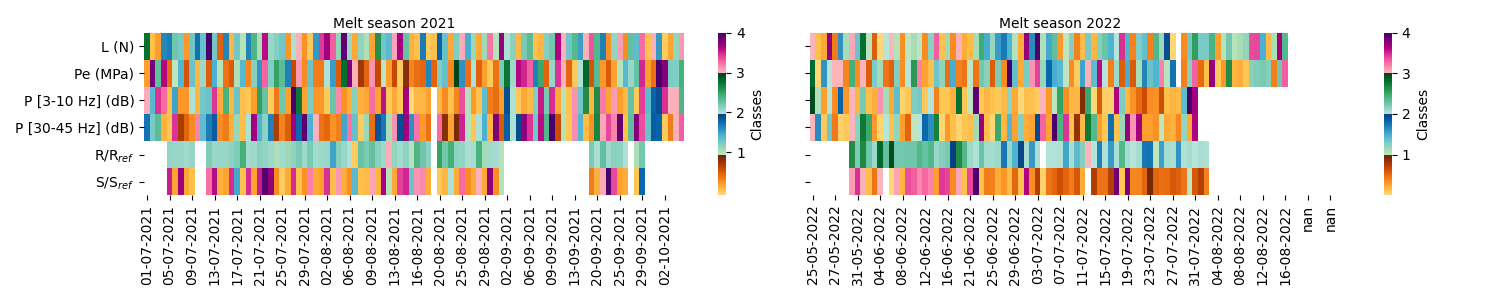

In [110]:
# color=[cmap(0.25), cmap(0.5), cmap(0.75), cmap(1)]

fig, axs = plt.subplots(1, 2, figsize=(15, 3), sharey=True)
for d in np.arange(0, len(df)):
    axs[d]=sns.heatmap(globals()[f'event_class_theta_{name[d]}_norm'].T, cmap=mymap, ax=axs[d], cbar_kws={'label': 'Classes', 'ticks':[1, 2, 3, 4]})
axs[0].text(0.35, 1.03, 'Melt season 2021', color='k', transform=axs[0].transAxes)
axs[1].text(0.35, 1.03, 'Melt season 2022', color='k', transform=axs[1].transAxes)
plt.tight_layout()
plt.savefig(path_fig_export+'classes_diurnal/classes_summary_norm.pdf', bbox_inches='tight')

In [111]:
event_class_melt_2021.replace(0,np.nan, inplace=True)
event_class_melt_2022.replace(0,np.nan, inplace=True)
event_class_date_melt_2021.replace(0,np.nan, inplace=True)
event_class_date_melt_2022.replace(0,np.nan, inplace=True)

In [112]:
event_class_melt_2021

L   Pe  P3_10  P30_45    R    S
01-07-2021  3  1.0    4.0     2.0  NaN  NaN
02-07-2021  1  4.0    2.0     2.0  NaN  NaN
03-07-2021  1  3.0    4.0     3.0  NaN  NaN
04-07-2021  2  4.0    4.0     1.0  NaN  NaN
05-07-2021  2  1.0    1.0     1.0  3.0  4.0
...        ..  ...    ...     ...  ...  ...
01-10-2021  2  4.0    2.0     2.0  NaN  NaN
02-10-2021  1  4.0    4.0     1.0  NaN  NaN
03-10-2021  1  2.0    3.0     1.0  NaN  NaN
04-10-2021  2  2.0    4.0     4.0  NaN  NaN
04-10-2021  4  3.0    3.0     4.0  NaN  NaN

[96 rows x 6 columns]

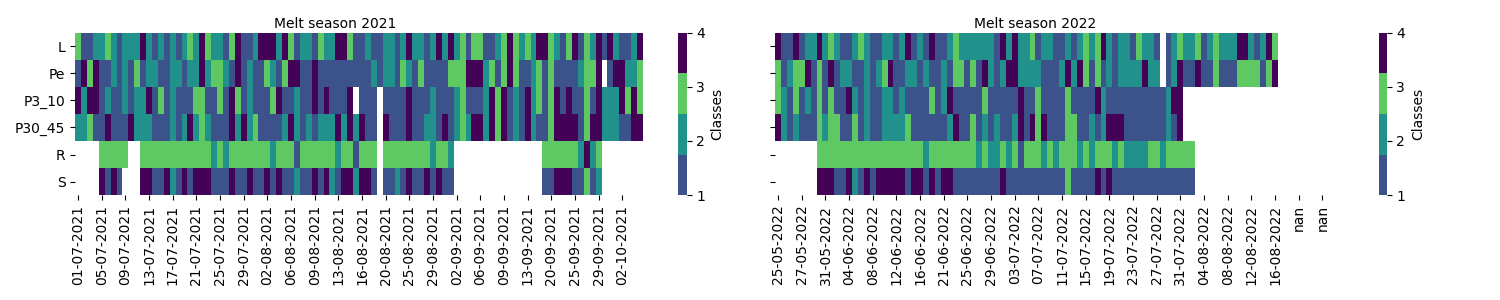

In [113]:
cmap=matplotlib.cm.get_cmap('viridis')
color=[cmap(0.25), cmap(0.5), cmap(0.75), cmap(1)]
fig, axs = plt.subplots(1, 2, figsize=(15, 3), sharey=True)
for d in np.arange(0, len(df)):
    axs[d]=sns.heatmap(globals()[f'event_class_{name[d]}'].T, cmap=color, ax=axs[d], cbar_kws={'label': 'Classes', 'ticks':[1, 2, 3, 4]})
axs[0].text(0.35, 1.03, 'Melt season 2021', color='k', transform=axs[0].transAxes)
axs[1].text(0.35, 1.03, 'Melt season 2022', color='k', transform=axs[1].transAxes)
plt.tight_layout()
plt.savefig(path_fig_export+'classes_diurnal/classes_summary.pdf', bbox_inches='tight')

In [114]:
event_class_melt_2021.replace(np.nan, 0, inplace=True)
event_class_date_melt_2021.replace(np.nan, 0, inplace=True)
event_class_melt_2022.replace(np.nan, 0, inplace=True)
event_class_date_melt_2022.replace(np.nan, 0, inplace=True)


In [115]:
event_class_melt_2021.reset_index(inplace=True)
event_class_date_melt_2021.reset_index(inplace=True)

In [116]:
event_class_melt_2022.reset_index(inplace=True)
event_class_date_melt_2022.reset_index(inplace=True)

In [117]:
event_class_melt_2022

index    L   Pe  P3_10  P30_45    R    S
0   25-05-2022  4.0  3.0    3.0     4.0  0.0  0.0
1   25-05-2022  1.0  1.0    2.0     2.0  0.0  0.0
2   26-05-2022  1.0  2.0    1.0     1.0  0.0  0.0
3   27-05-2022  4.0  3.0    3.0     2.0  0.0  0.0
4   27-05-2022  1.0  3.0    1.0     1.0  0.0  0.0
..         ...  ...  ...    ...     ...  ...  ...
91         NaN  0.0  0.0    0.0     0.0  0.0  0.0
92         NaN  0.0  0.0    0.0     0.0  0.0  0.0
93         NaN  0.0  0.0    0.0     0.0  0.0  0.0
94         NaN  0.0  0.0    0.0     0.0  0.0  0.0
95         NaN  0.0  0.0    0.0     0.0  0.0  0.0

[96 rows x 7 columns]

In [118]:
event_class_melt_2022 = event_class_melt_2022[0:-11]
event_class_date_melt_2022 = event_class_date_melt_2022[0:-11]


### Mask events for 2021

In [119]:
# Mask for Runoff 2021
mask1=np.arange(64, 78)
mask2=np.arange(84, 96)
mask=np.append(mask1, mask2)
for i in mask:
    event_class_melt_2021.loc[i, ['L', 'Pe', 'P3_10', 'P30_45', 'R', 'S']]=0
    event_class_date_melt_2021.loc[i, ['L', 'Pe', 'P3_10', 'P30_45', 'R', 'S']]=0

In [120]:
mask_F1=np.arange(0, 9)
mask_F2=np.arange(11, 17)
mask_F3=np.arange(19, 27)
mask_F4=np.arange(35, 39)
mask_F5=np.arange(41, 43)
mask_F=np.append(mask_F1, mask_F2)
mask_F=np.append(mask_F, mask_F3)
mask_F=np.append(mask_F, mask_F4)
mask_F_21=np.append(mask_F, mask_F5)

for i in mask_F_21:
    event_class_melt_2021.loc[i, ['L']]=0
    event_class_date_melt_2021.loc[i, ['L']]=0

In [121]:
mask_Pe1=np.arange(0, 17)
mask_Pe2=np.arange(19, 27)
mask_Pe3=np.arange(19, 27)
mask_Pe4=np.arange(30, 33)
mask_Pe5=np.arange(47, 62)
mask_Pe6=np.arange(63, 81)

mask_Pe=np.append(mask_Pe1, mask_Pe2)
mask_Pe=np.append(mask_Pe, mask_Pe3)
mask_Pe=np.append(mask_Pe, mask_Pe4)
mask_Pe=np.append(mask_Pe, mask_Pe5)
mask_Pe_21=np.append(mask_Pe, mask_Pe6)

for i in mask_Pe_21:
    event_class_melt_2021.loc[i, ['Pe']]=0
    event_class_date_melt_2021.loc[i, ['Pe']]=0

In [122]:
mask_P3045_21=np.arange(77, 79)
for i in mask_P3045_21:
    event_class_melt_2021.loc[i, ['P30_45']]=0
    event_class_date_melt_2021.loc[i, ['P30_45']]=0

In [123]:
mask_R1=np.arange(0, 4)
mask_R2=np.arange(64, 79)
mask_R3=np.arange(90, 96)
mask_R=np.append(mask_R1, mask_R2)
mask_R_21=np.append(mask_R, mask_R3)

for i in mask_R_21:
    event_class_melt_2021.loc[i, ['R']]=0
    event_class_date_melt_2021.loc[i, ['R']]=0

In [124]:
mask_S1=np.arange(0, 4)
mask_S2=np.arange(87, 96)
mask_S_21=np.append(mask_R1, mask_R2)

for i in mask_S_21:
    event_class_melt_2021.loc[i, ['S']]=0
    event_class_date_melt_2021.loc[i, ['S']]=0

### Mask for event 2022

In [125]:
mask=np.arange(0, 7)
for i in mask:
    event_class_melt_2022.loc[i, ['L', 'Pe', 'P3_10', 'P30_45', 'R', 'S']]=0
    event_class_date_melt_2022.loc[i, ['L', 'Pe', 'P3_10', 'P30_45', 'R', 'S']]=0

/home/colili/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [126]:
mask_F1=np.arange(0, 9)
mask_F2=np.arange(12, 16)
mask_F3=np.arange(18, 36)
mask_F4=np.arange(43, 50)
mask_F5=np.arange(59, 72)
mask_F6=np.arange(73, 85)
mask_F = np.append(mask_F1, mask_F2)
mask_F = np.append(mask_F, mask_F3)
mask_F = np.append(mask_F, mask_F4)
mask_F = np.append(mask_F, mask_F5)
mask_F_22 = np.append(mask_F, mask_F6)

for i in mask_F_22:
    event_class_melt_2022.loc[i, ['L']]=0
    event_class_date_melt_2022.loc[i, ['L']]=0

In [127]:
mask_Pe1=np.arange(0, 9)
mask_Pe2=np.arange(12, 14)
mask_Pe3=np.arange(20, 29)
mask_Pe4=np.arange(45, 49)

mask_Pe = np.append(mask_Pe1, mask_Pe2)
mask_Pe = np.append(mask_Pe, mask_Pe3)
mask_Pe_22= np.append(mask_Pe, mask_Pe4)

for i in mask_Pe_22:
    event_class_melt_2022.loc[i, ['Pe']]=0
    event_class_date_melt_2022.loc[i, ['Pe']]=0

In [128]:
mask_P_22=np.arange(0, 8)
for i in mask_P_22:
    event_class_melt_2022.loc[i, ['P3_10', 'P30_45']]=0
    event_class_date_melt_2022.loc[i, ['P3_10', 'P30_45']]=0

In [129]:
mask_S_R_22=np.arange(72, 85)
for i in mask_S_R_22:
    event_class_melt_2022.loc[i, ['R', 'S']]=0
    event_class_date_melt_2022.loc[i, ['R', 'S']]=0

In [130]:
# event_class_melt_2022.loc[2, ['L']]=np.nan
# event_class_melt_2022.loc[3, ['L']]=np.nan
# event_class_melt_2022.loc[6, ['L']]=np.nan

# event_class_date_melt_2022.loc[2, ['L']]=np.nan
# event_class_date_melt_2022.loc[3, ['L']]=np.nan
# event_class_date_melt_2022.loc[6, ['L']]=np.nan

# event_class_melt_2022.loc[2, ['Pe']]=np.nan
# event_class_date_melt_2022.loc[2, ['Pe']]=np.nan

# # event_class_melt_2022.loc[, ['S']]=np.nan
# # event_class_melt_2022.loc[2, ['R']]=np.nan


# event_class_melt_2022.loc[3, ['P3_10']]=np.nan
# event_class_melt_2022.loc[4, ['P3_10']]=np.nan

# event_class_date_melt_2022.loc[3, ['P3_10']]=np.nan
# event_class_date_melt_2022.loc[4, ['P3_10']]=np.nan

In [131]:
# event_class_melt_2022

In [132]:
# fig, ax = plt.subplots()
# ax.plot(event_class_melt_2022.index, event_class_melt_2022['S'])

In [133]:
event_class_melt_2021.set_index('index', inplace=True)
event_class_melt_2022.set_index('index', inplace=True)

In [134]:
event_class_date_melt_2021.set_index('Start', inplace=True)
event_class_date_melt_2022.set_index('Start', inplace=True)

In [135]:
event_class_melt_2021.index.names = [None]
event_class_melt_2022.index.names = [None]

event_class_date_melt_2021.index.names = [None]
event_class_date_melt_2022.index.names = [None]

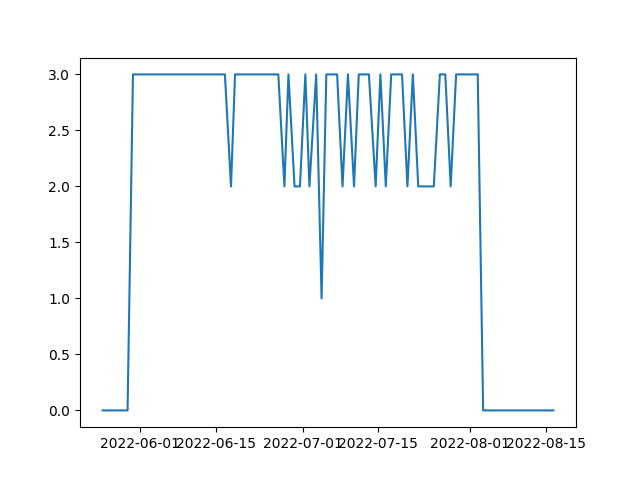

In [136]:
fig, ax = plt.subplots()
ax.plot(event_class_date_melt_2022['R'])

In [137]:
idx_velocity_21_1=df_data_raw.loc[df_data_raw['TIMESTAMP']=='2021-07-01 00:00:00'].index[0]
idx_velocity_21_2=df_data_raw.loc[df_data_raw['TIMESTAMP']=='2021-10-04 21:00:00'].index[0]
idx_velocity_21=np.arange(idx_velocity_21_1, idx_velocity_21_2)


In [138]:
idx_velocity_22_1=df_data_raw.loc[df_data_raw['TIMESTAMP']=='2022-05-25 00:00:00'].index[0]
idx_velocity_22_2=df_data_raw.loc[df_data_raw['TIMESTAMP']=='2022-08-16 15:00:00'].index[0]
idx_velocity_22=np.arange(idx_velocity_22_1, idx_velocity_22_2)

In [139]:
event_class_2021 = pd.concat([event_class_date_melt_2021, df_melt_2021.set_index('TIMESTAMP')], axis=1)

In [140]:
event_class_2022 = pd.concat([event_class_date_melt_2022, df_melt_2022.set_index('TIMESTAMP')], axis=1)

In [141]:
# event_class_2022[60:80]

In [142]:
event_class_melt_2021_pad = event_class_2021.iloc[:, :6].interpolate(method='pad')

In [143]:
event_class_melt_2022_pad = event_class_2022.iloc[:, :6].interpolate(method='pad')

In [144]:
event_class_date_melt_2022[0:40]

L   Pe  P3_10  P30_45    R    S
2022-05-25 00:00:00  0.0  0.0    0.0     0.0  0.0  0.0
2022-05-25 06:00:00  0.0  0.0    0.0     0.0  0.0  0.0
2022-05-26 12:00:00  0.0  0.0    0.0     0.0  0.0  0.0
2022-05-27 03:00:00  0.0  0.0    0.0     0.0  0.0  0.0
2022-05-27 18:00:00  0.0  0.0    0.0     0.0  0.0  0.0
2022-05-28 15:00:00  0.0  0.0    0.0     0.0  0.0  0.0
2022-05-29 15:00:00  0.0  0.0    0.0     0.0  0.0  0.0
2022-05-30 15:00:00  0.0  0.0    0.0     0.0  3.0  4.0
2022-05-31 15:00:00  0.0  0.0    1.0     2.0  3.0  4.0
2022-06-01 12:00:00  3.0  4.0    3.0     3.0  3.0  4.0
2022-06-02 15:00:00  2.0  1.0    1.0     3.0  3.0  1.0
2022-06-03 12:00:00  1.0  2.0    1.0     1.0  3.0  1.0
2022-06-04 09:00:00  0.0  0.0    4.0     1.0  3.0  4.0
2022-06-05 15:00:00  0.0  0.0    2.0     3.0  3.0  2.0
2022-06-06 18:00:00  0.0  1.0    1.0     1.0  3.0  1.0
2022-06-07 12:00:00  0.0  2.0    2.0     2.0  3.0  4.0
2022-06-08 15:00:00  1.0  1.0    1.0     1.0  3.0  1.0
2022-06-09 18:00:00  1.0  2.0    1.0     1.0  3.0  4.0
2022-06-10 18:00:00  0.0  3.0    2.0     2.0  3.0  4.0
2022-06-11 15:00:00  0.0  4.0    2.0     2.0  3.0  4.0
2022-06-12 15:00:00  0.0  0.0    1.0     2.0  3.0  4.0
2022-06-13 15:00:00  0.0  0.0    2.0     2.0  3.0  4.0
2022-06-14 15:00:00  0.0  0.0    1.0     3.0  3.0  1.0
2022-06-15 15:00:00  0.0  0.0    1.0     1.0  3.0  4.0
2022-06-16 15:00:00  0.0  0.0    1.0     1.0  3.0  4.0
2022-06-17 18:00:00  0.0  0.0    1.0     1.0  2.0  1.0
2022-06-18 12:00:00  0.0  0.0    3.0     1.0  3.0  4.0
2022-06-19 15:00:00  0.0  0.0    1.0     1.0  3.0  1.0
2022-06-21 15:00:00  0.0  0.0    2.0     1.0  3.0  4.0
2022-06-22 12:00:00  0.0  1.0    4.0     2.0  3.0  4.0
2022-06-23 09:00:00  0.0  3.0    1.0     4.0  3.0  1.0
2022-06-24 12:00:00  0.0  3.0    1.0     1.0  3.0  1.0
2022-06-25 12:00:00  0.0  1.0    1.0     1.0  3.0  1.0
2022-06-26 12:00:00  0.0  3.0    1.0     3.0  3.0  1.0
2022-06-27 15:00:00  0.0  1.0    1.0     1.0  2.0  1.0
2022-06-28 09:00:00  0.0  4.0    3.0     2.0  3.0  1.0
2022-06-29 12:00:00  2.0  2.0    1.0     1.0  2.0  1.0
2022-06-30 12:00:00  1.0  1.0    1.0     2.0  2.0  1.0
2022-07-01 12:00:00  4.0  2.0    1.0     1.0  3.0  4.0
2022-07-02 06:00:00  2.0  4.0    1.0     1.0  2.0  1.0

In [145]:
event_class_melt_2021_pad[50:80]

L   Pe  P3_10  P30_45    R    S
2021-07-07 06:00:00  0.0  0.0    2.0     4.0  3.0  1.0
2021-07-07 09:00:00  0.0  0.0    2.0     4.0  3.0  1.0
2021-07-07 12:00:00  0.0  0.0    2.0     4.0  3.0  1.0
2021-07-07 15:00:00  0.0  0.0    1.0     1.0  3.0  4.0
2021-07-07 18:00:00  0.0  0.0    1.0     1.0  3.0  4.0
2021-07-07 21:00:00  0.0  0.0    1.0     1.0  3.0  4.0
2021-07-08 00:00:00  0.0  0.0    1.0     1.0  3.0  4.0
2021-07-08 03:00:00  0.0  0.0    1.0     1.0  3.0  4.0
2021-07-08 06:00:00  0.0  0.0    1.0     1.0  3.0  4.0
2021-07-08 09:00:00  0.0  0.0    1.0     1.0  3.0  4.0
2021-07-08 12:00:00  0.0  0.0    1.0     1.0  3.0  4.0
2021-07-08 15:00:00  0.0  0.0    1.0     1.0  3.0  4.0
2021-07-08 18:00:00  0.0  0.0    1.0     1.0  3.0  1.0
2021-07-08 21:00:00  0.0  0.0    1.0     1.0  3.0  1.0
2021-07-09 00:00:00  0.0  0.0    1.0     1.0  3.0  1.0
2021-07-09 03:00:00  0.0  0.0    1.0     1.0  3.0  1.0
2021-07-09 06:00:00  0.0  0.0    1.0     1.0  3.0  1.0
2021-07-09 09:00:00  0.0  0.0    2.0     1.0  3.0  0.0
2021-07-09 12:00:00  0.0  0.0    2.0     1.0  3.0  0.0
2021-07-09 15:00:00  0.0  0.0    2.0     1.0  3.0  0.0
2021-07-09 18:00:00  0.0  0.0    2.0     1.0  3.0  0.0
2021-07-09 21:00:00  0.0  0.0    2.0     1.0  3.0  0.0
2021-07-10 00:00:00  0.0  0.0    2.0     1.0  3.0  0.0
2021-07-10 03:00:00  0.0  0.0    2.0     1.0  3.0  0.0
2021-07-10 06:00:00  0.0  0.0    2.0     1.0  3.0  0.0
2021-07-10 09:00:00  0.0  0.0    2.0     1.0  3.0  0.0
2021-07-10 12:00:00  0.0  0.0    2.0     1.0  3.0  0.0
2021-07-10 15:00:00  2.0  0.0    1.0     4.0  0.0  0.0
2021-07-10 18:00:00  2.0  0.0    1.0     4.0  0.0  0.0
2021-07-10 21:00:00  2.0  0.0    1.0     4.0  0.0  0.0

In [146]:
event_class_melt_2021_pad.index=event_class_melt_2021_pad.index.format(formatter=lambda x: x.strftime('%d-%m-%Y %H'))

In [147]:
event_class_melt_2022_pad.index=event_class_melt_2022_pad.index.format(formatter=lambda x: x.strftime('%d-%m-%Y %H'))

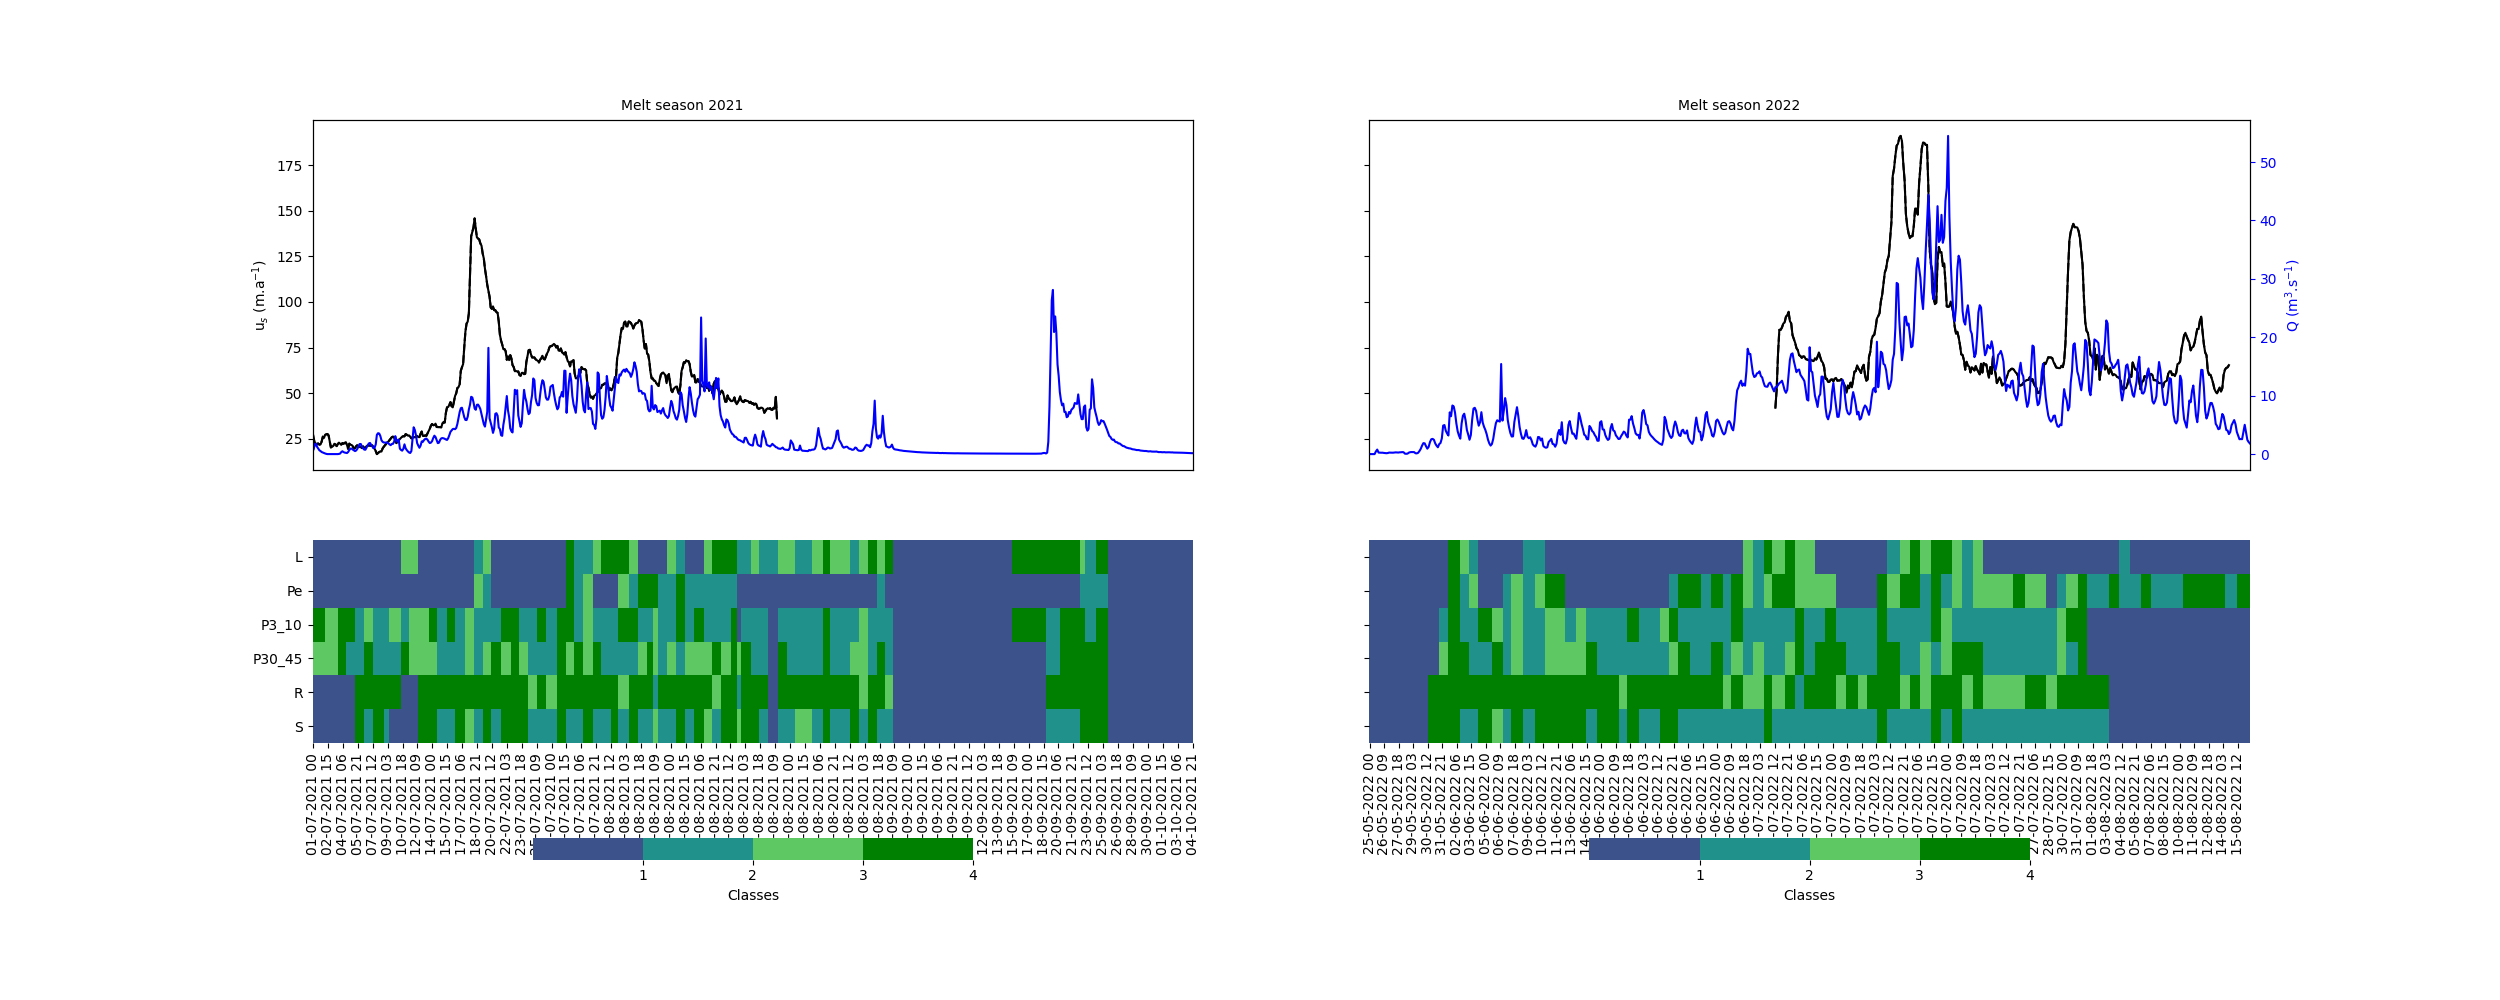

In [148]:
cmap=matplotlib.cm.get_cmap('viridis')
color=[cmap(0.25), cmap(0.5), cmap(0.75), 'g']
fig, axs = plt.subplots(2, 2, figsize=(25, 10), sharey='row')


for d in np.arange(0, len(df)):

    axs[1][d]=sns.heatmap(globals()[f'event_class_{name[d]}_pad'].T, cmap=color, ax=axs[1][d], cbar_kws={'label': 'Classes', 'ticks':[1, 2, 3, 4], 'orientation':'horizontal', 'pad':0.27, "shrink": 0.5})
    # axs[1][d]=sns.heatmap(globals()[f'event_class_{name[d]}_pad_nan'].T, cmap='viridis', ax=axs[1][d], linewidths=0)
    # axs[1][d].margins(x=0)
    
axs[0][0].plot(df_data_raw['TIMESTAMP'][idx_velocity_21], df_data_raw['KNG6'][idx_velocity_21], 'k--')
axs[0][0].plot(df_data_raw['TIMESTAMP'][idx_velocity_21], df_data_raw['KNG6'][idx_velocity_21], 'k')
axs[0][0].set_ylabel('u$_s$ (m.a$^{-1}$)')
ax1=axs[0][0].twinx()
ax1.plot(df_data_raw['TIMESTAMP'][idx_velocity_21], df_data_raw['Runoff'][idx_velocity_21], 'b')
ax1.get_yaxis().set_visible(False)
axs[0][0].get_xaxis().set_visible(False)

axs[0][1].plot(df_data_raw['TIMESTAMP'][idx_velocity_22], df_data_raw['KNG6'][idx_velocity_22],'k--')
axs[0][1].plot(df_data_raw['TIMESTAMP'][idx_velocity_22], df_data_raw['KNG6'][idx_velocity_22], 'k')
ax2=axs[0][1].twinx()
ax2.plot(df_data_raw['TIMESTAMP'][idx_velocity_22], df_data_raw['Runoff'][idx_velocity_22],'b')
ax2.set_ylabel('Q (m$^3$.s$^{-1}$)', color='b')
ax2.tick_params(axis='y', color='b', labelcolor='b')
ax2.get_shared_y_axes().join(ax2, ax1)
axs[0][1].get_xaxis().set_visible(False)


axs[0][0].text(0.35, 1.03, 'Melt season 2021', color='k', transform=axs[0][0].transAxes)
axs[0][1].text(0.35, 1.03, 'Melt season 2022', color='k', transform=axs[0][1].transAxes)

axs[0][1].margins(x=0)
axs[0][0].margins(x=0)
# plt.tight_layout()
plt.savefig(path_fig_export+'classes_diurnal/classes_summary_prop.pdf', bbox_inches='tight')

In [149]:
date_2021 = pd.DataFrame({'Date':event_class_2021.index})
date_2022 = pd.DataFrame({'Date':event_class_2022.index})

In [150]:
event_delim_21 = pd.concat([df_event_time_melt_2021.set_index('Start'), date_2021.set_index('Date')], axis=1)
event_delim_22 = pd.concat([df_event_time_melt_2022.set_index('Start'), date_2022.set_index('Date')], axis=1)

In [151]:
i_melt_2021 = event_delim_21.reset_index().dropna(subset=['Event']).index
i_melt_2022 = event_delim_22.reset_index().dropna(subset=['Event']).index

ii_melt_2021 = event_delim_21.dropna(subset=['Event']).index
ii_melt_2022 = event_delim_22.dropna(subset=['Event']).index

In [152]:
tick_melt_2021 = pd.DataFrame({'Start':event_delim_21.reset_index().dropna(subset=['Event'])['index']})
tick_melt_2022 = pd.DataFrame({'Start':event_delim_22.reset_index().dropna(subset=['Event'])['index']})

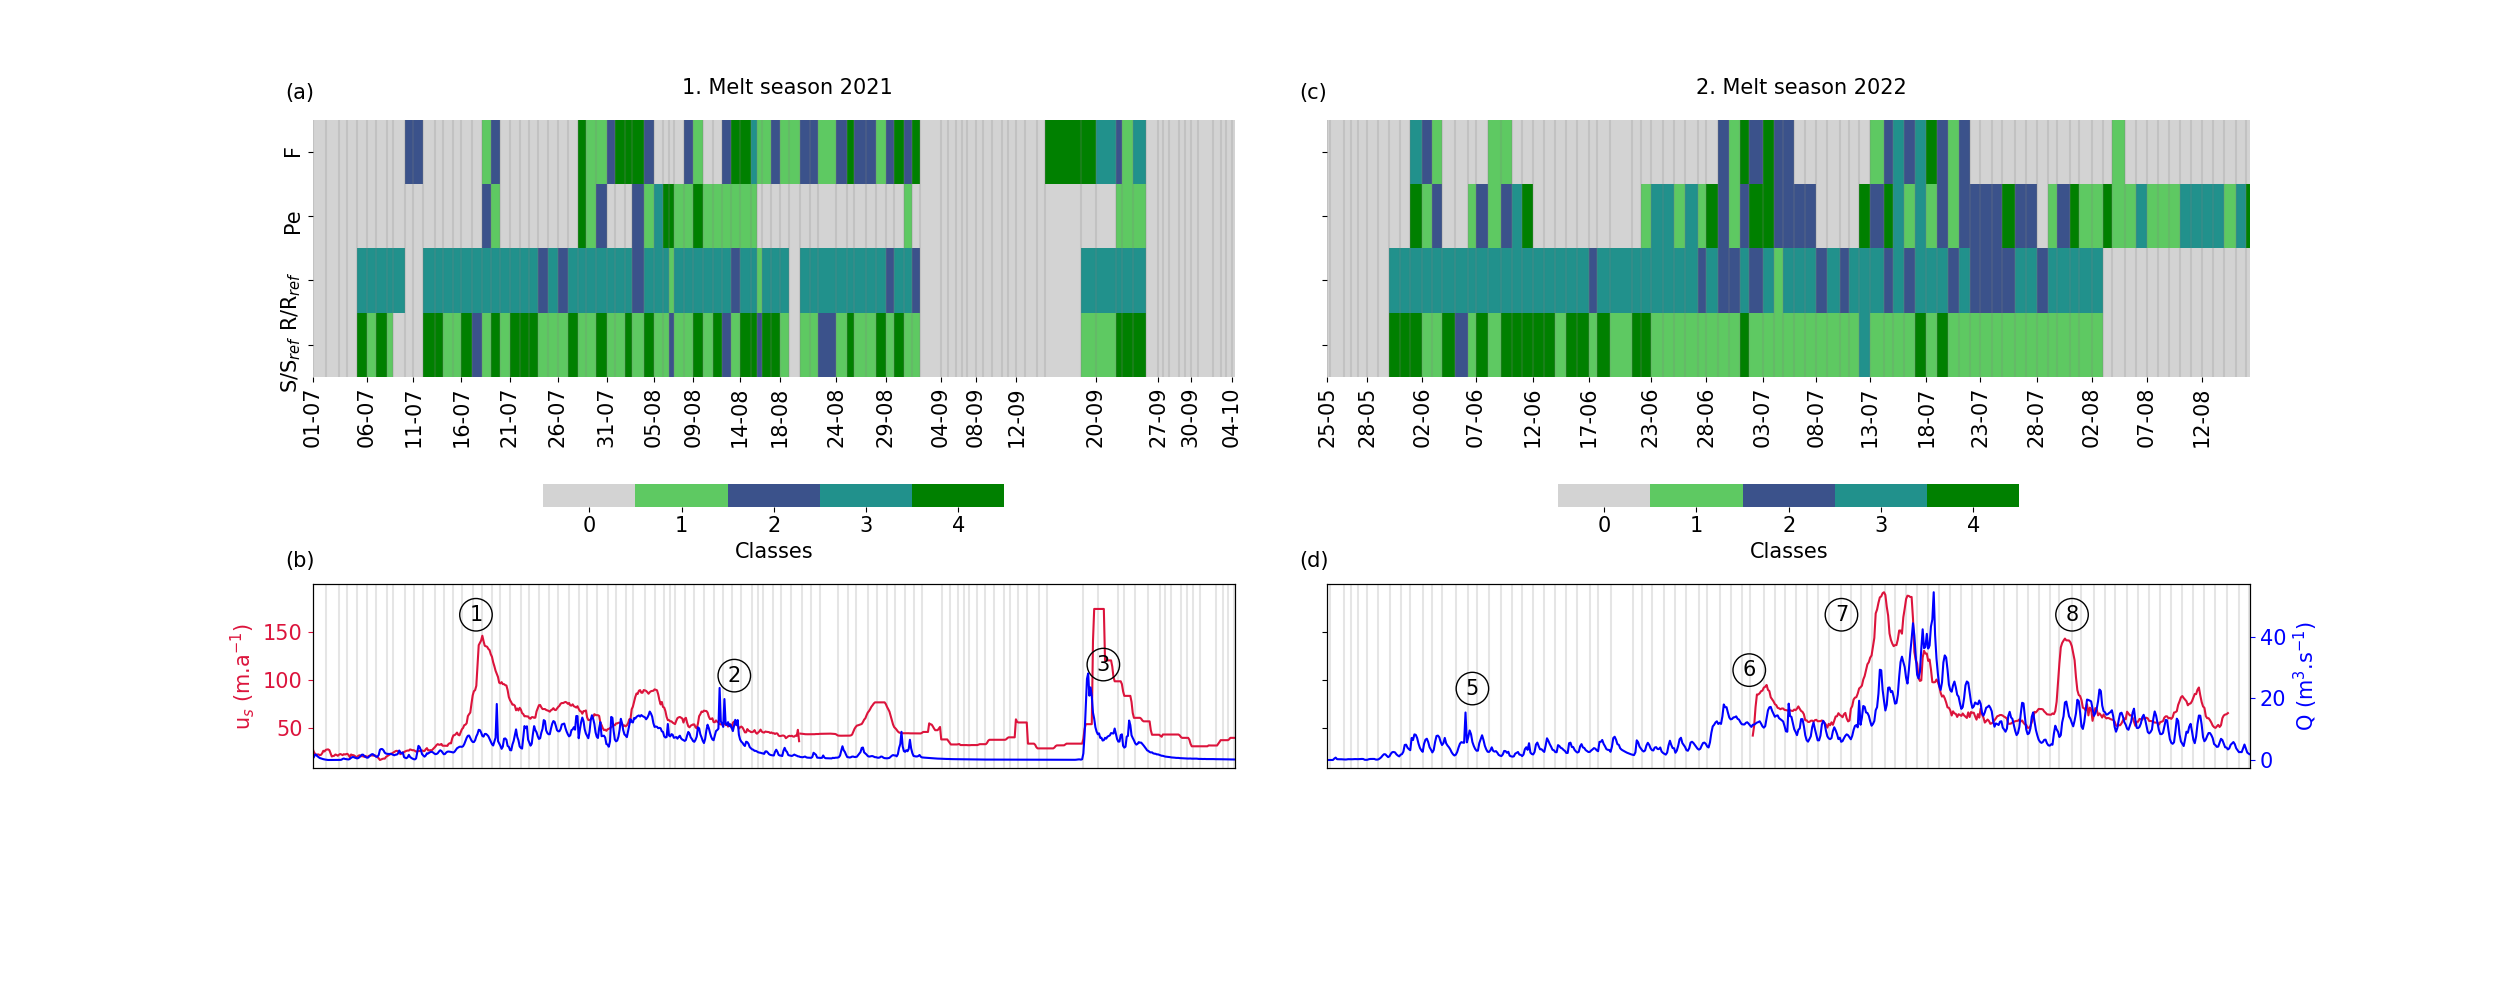

In [153]:
cmap=matplotlib.cm.get_cmap('viridis')
color=['lightgray', cmap(0.75), cmap(0.25), cmap(0.5), 'g']
fig, axs = plt.subplots(2, 2, figsize=(25, 10), sharey='row')


for d in np.arange(0, len(df)):
    
    globals()[f'event_class_{name[d]}_pad'] = globals()[f'event_class_{name[d]}_pad'][['L', 'Pe', 'R', 'S']]
    globals()[f'event_class_{name[d]}_pad'].replace(np.nan, 0, inplace=True)
    globals()[f'event_class_{name[d]}_pad'].columns=['F', 'Pe', 'R/R$_{ref}$', 'S/S$_{ref}$']
    # axs[1][d]=sns.heatmap(globals()[f'event_class_{name[d]}_pad_nan'].T, cmap=color, ax=axs[1][d], cbar_kws={'label': 'Classes',  'ticks':[1, 2, 3, 4], 'orientation':'horizontal', 'pad':0.39, "shrink": 0.5})
    axs[0][d]=sns.heatmap(globals()[f'event_class_{name[d]}_pad'].T, cmap=color, ax=axs[0][d], cbar_kws={'label': 'Classes',  'ticks':[0.4, 1.2, 2, 2.8, 3.6], 'orientation':'horizontal', 'pad':0.25, "shrink": 0.5})
    # event_class_2021.iloc[:, :6]
    axs[0][d].tick_params(labelsize=15)
    # axs[0][d].collection[0].colorbar.set_ticklabels(['0', '1', '2', '3', '4'])
    cax = axs[0][d].figure.axes[-1]
    cax.tick_params(labelsize=15)
    cax.xaxis.label.set_size(15)
    cax.set_xticklabels(['0', '1', '2', '3', '4'])
    
    for i in np.arange(0, len(globals()[f'i_{name[d]}'])):
        axs[0][d].axvline(globals()[f'i_{name[d]}'][i], color='grey', alpha=0.2)
        axs[1][d].axvline(globals()[f'ii_{name[d]}'][i], color='grey', alpha=0.2)
    
    i=pd.to_datetime(globals()[f'tick_{name[d]}'].set_index('Start').index, format='%d-%m-%Y, %H')
    # print(i.iloc[:, 1])
    index=i.format(formatter=lambda x: x.strftime('%d-%m'))
    
    axs[0][d].set_xticks(globals()[f'i_{name[d]}'][0::5] , index[0::5])


KNG7_median = df_data_raw['KNG7'].rolling(18).median()
KNG7_median_2 = df_data_raw['KNG7'].rolling(80).mean()

axs[1][0].plot(df_data_raw['TIMESTAMP'][idx_velocity_21], df_data_raw['KNG6'][idx_velocity_21], color='crimson', linestyle='-')
axs[1][0].plot(df_data_raw['TIMESTAMP'][idx_velocity_21][405:], KNG7_median[idx_velocity_21][405:], 'crimson')
axs[1][0].set_ylabel('u$_s$ (m.a$^{-1}$)', color='crimson', fontsize=15)
axs[1][0].tick_params(axis='y', color='crimson', labelcolor='crimson', labelsize=15)

ax1=axs[1][0].twinx()
ax1.plot(df_data_raw['TIMESTAMP'][idx_velocity_21], df_data_raw['Runoff'][idx_velocity_21], 'b')
ax1.get_yaxis().set_visible(False)
axs[1][0].get_xaxis().set_visible(False)

# axs[1][1].get_xaxis().set_visible(False)
axs[1][1].plot(df_data_raw['TIMESTAMP'][idx_velocity_22], df_data_raw['KNG6'][idx_velocity_22], color='crimson', linestyle='-')
axs[1][1].plot(df_data_raw['TIMESTAMP'][idx_velocity_22][530:], KNG7_median[idx_velocity_22][530:], 'crimson')
ax2=axs[1][1].twinx()
ax2.plot(df_data_raw['TIMESTAMP'][idx_velocity_22], df_data_raw['Runoff'][idx_velocity_22],'b')
ax2.set_ylabel('Q (m$^3$.s$^{-1}$)', color='b', fontsize=15)
ax2.tick_params(axis='y', color='b', labelcolor='b', labelsize=15)
axs[1][1].tick_params(axis='x', labelsize=15)
ax2.get_shared_y_axes().join(ax2, ax1)
axs[1][1].get_xaxis().set_visible(False)


axs[0][0].text(0.4, 1.1, '1. Melt season 2021', color='k', fontsize=15, transform=axs[0][0].transAxes)
axs[0][1].text(0.4, 1.1, '2. Melt season 2022', color='k', fontsize=15, transform=axs[0][1].transAxes)

axs[1][1].margins(x=0)
axs[1][0].margins(x=0)

# axs[0][0].annotate('', xy=(0.024, 1.03), va='center',
#                 ha='center', xytext=(0.026, 1.03), xycoords='axes fraction', horizontalalignment="center", 
#                 arrowprops=dict(arrowstyle="<->", color='k'))
# axs[0][0].text(0.04, 1.09, 'Event', color='k', fontsize=15, transform=axs[0][0].transAxes)
axs[0][0].text(-0.03, 1.08, '(a)', color='k', fontsize=15, transform=axs[0][0].transAxes)
axs[0][1].text(-0.03, 1.08, '(c)', color='k', fontsize=15, transform=axs[0][1].transAxes)
axs[1][0].text(-0.03, 1.09, '(b)', color='k', fontsize=15, transform=axs[1][0].transAxes)
axs[1][1].text(-0.03, 1.09, '(d)', color='k', fontsize=15, transform=axs[1][1].transAxes)

axs[1][0].text(0.17, 0.8, '1', color='k', fontsize=15, transform=axs[1][0].transAxes, bbox = dict(boxstyle="circle", facecolor='none', edgecolor='k'))
# axs[0][0].text(0.3, 0.8, '2', color='k', fontsize=15, transform=axs[0][0].transAxes, bbox = dict(boxstyle="circle", facecolor='none', edgecolor='k'))
axs[1][0].text(0.45, 0.47, '2', color='k', fontsize=15, transform=axs[1][0].transAxes, bbox = dict(boxstyle="circle", facecolor='none', edgecolor='k'))
axs[1][0].text(0.85, 0.53, '3', color='k', fontsize=15, transform=axs[1][0].transAxes, bbox = dict(boxstyle="circle", facecolor='none', edgecolor='k'))

axs[1][1].text(0.15, 0.4, '5', color='k', fontsize=15, transform=axs[1][1].transAxes, bbox = dict(boxstyle="circle", facecolor='none', edgecolor='k'))
axs[1][1].text(0.45, 0.5, '6', color='k', fontsize=15, transform=axs[1][1].transAxes, bbox = dict(boxstyle="circle", facecolor='none', edgecolor='k'))
axs[1][1].text(0.55, 0.8, '7', color='k', fontsize=15, transform=axs[1][1].transAxes, bbox = dict(boxstyle="circle", facecolor='none', edgecolor='k'))
axs[1][1].text(0.80, 0.8, '8', color='k', fontsize=15, transform=axs[1][1].transAxes, bbox = dict(boxstyle="circle", facecolor='none', edgecolor='k'))

axs[1][0].set_box_aspect(1/5)
axs[1][1].set_box_aspect(1/5)

plt.subplots_adjust(wspace=0.1, hspace=-0.2)

# plt.tight_layout()
plt.savefig(path_fig_export+'classes_diurnal/classes_summary_prop_velocity_runoff.png', bbox_inches='tight')

## Correlation diurnal/velocity

In [154]:
df_velocity_2021 = df_data_raw[['TIMESTAMP', 'KNG6', 'KNG7']][128:896]
df_velocity_2022 = df_data_raw[['TIMESTAMP', 'KNG6', 'KNG7']][2753:3423]

In [155]:
%matplotlib widget
b = signal.butter(1, [1/1.5, 1/0.25]/fs, 'band')[0]
a = signal.butter(1, [1/1.5, 1/0.25]/fs, 'band')[1]

idx_21 = np.isfinite(df_velocity_2021['KNG6'])
filterbandpass_KNG6_diurnal_2021=signal.filtfilt(b, a, df_velocity_2021['KNG6'][idx_21])

idx_22 = np.isfinite(df_velocity_2022['KNG6'])
filterbandpass_KNG6_diurnal_2022=signal.filtfilt(b, a, df_velocity_2022['KNG6'][idx_22])


In [156]:
df_filter_diurnal_KNG6_melt_2021=pd.DataFrame({'TIMESTAMP':df_velocity_2021['TIMESTAMP'][idx_21], 'KNG6':filterbandpass_KNG6_diurnal_2021})
df_filter_diurnal_KNG6_melt_2022=pd.DataFrame({'TIMESTAMP':df_velocity_2022['TIMESTAMP'][idx_22], 'KNG6':filterbandpass_KNG6_diurnal_2022})

In [157]:
result_21 = pd.concat([df_filter_diurnal_KNG6_melt_2021.set_index('TIMESTAMP'), df_filter_diurnal_Pe_melt_2021.set_index('TIMESTAMP')]
                   , axis=1, join='inner')
result_22 = pd.concat([df_filter_diurnal_KNG6_melt_2022.set_index('TIMESTAMP'), df_filter_diurnal_Pe_melt_2022.set_index('TIMESTAMP')]
                   , axis=1, join='inner')

In [158]:
# result

In [159]:
s, inter = np.poly1d(np.polyfit(df_event['Runoff'], df_event[str(df_temp_theta.columns[j])], 1))

IndexError: index 95 is out of bounds for axis 0 with size 7

In [ ]:
a_21 = np.poly1d(np.polyfit(result_21['KNG6'], result_21['Pe'], 1))
a_22 = np.poly1d(np.polyfit(result_22['KNG6'], result_22['Pe'], 1))
# np.where(~np.isfinite(dep_3))
# xseq_21 = np.linspace(result_21['KNG6'].min(), result_21['KNG6'].max(), num=100)

In [ ]:
a_22

In [ ]:
x_21=np.linspace(-30, 30, 100)

In [ ]:
fig, axs=plt.subplots()
axs.scatter(result_21['KNG6'], result_21['Pe'], c='k', label='2021')
axs.scatter(result_22['KNG6'], result_22['Pe'], c='b', label='2022')
axs.set_ylabel('Diurnal water pressure (MPa)', fontsize=15)
axs.set_xlabel('Diurnal velocity (m a$^{-1}$)', fontsize=15)
axs.legend()
axs.tick_params(labelsize=15)
plt.savefig(path_fig_export+'classes_diurnal/comp_pe_velocity.pdf', bbox_inches='tight')

In [ ]:
df_filter_diurnal_L_melt_2021

In [ ]:
# event_class_melt_2021_pad_nan=event_class_melt_2021_pad.reset_index()
# event_class_melt_2022_pad_nan=event_class_melt_2022_pad.reset_index()

In [ ]:
# i_Q_nan_2021=np.array(list(set(event_class_melt_2021_pad_nan.index)^set(idx_Q)))
# i_Q_nan_2022=np.array(list(set(event_class_melt_2022_pad_nan.index)^set(idx_Q_22)))

In [ ]:
# i_L_nan_2021=np.array(list(set(event_class_melt_2021_pad_nan.index)^set(idx_L)))
# i_L_nan_2022=np.array(list(set(event_class_melt_2022_pad_nan.index)^set(idx_L_22)))

In [ ]:
# i_Pe_nan_2021=np.array(list(set(event_class_melt_2021_pad_nan.index)^set(idx_Pe)))
# i_Pe_nan_2022=np.array(list(set(event_class_melt_2022_pad_nan.index)^set(idx_Pe_22)))

In [ ]:
# i_P310_nan_2022=np.array(list(set(event_class_melt_2022_pad_nan.index)^set(idx_P310_22)))

In [ ]:
# i_P3045_nan_2021=np.array(list(set(event_class_melt_2021_pad_nan.index)^set(idx_P)))
# i_P3045_nan_2022=np.array(list(set(event_class_melt_2022_pad_nan.index)^set(idx_P3045_22)))

In [ ]:
# i_R_nan_2021=np.array(list(set(event_class_melt_2021_pad_nan.index)^set(idx_R)))
# i_R_nan_2022=np.array(list(set(event_class_melt_2022_pad_nan.index)^set(idx_R_22)))

In [ ]:
# i_S_nan_2021=np.array(list(set(event_class_melt_2021_pad_nan.index)^set(idx_S)))
# i_S_nan_2022=np.array(list(set(event_class_melt_2022_pad_nan.index)^set(idx_S_22)))

In [ ]:
# event_class_melt_2021_pad_nan.loc[i_R_nan_2021, 'R']=np.nan
# event_class_melt_2022_pad_nan.loc[i_R_nan_2022, 'R']=np.nan
# event_class_melt_2021_pad_nan.loc[i_S_nan_2021, 'S']=np.nan
# event_class_melt_2022_pad_nan.loc[i_S_nan_2022, 'S']=np.nan
# event_class_melt_2022_pad_nan.loc[i_P310_nan_2022, 'P3_10']=np.nan
# event_class_melt_2021_pad_nan.loc[i_P3045_nan_2021, 'P30_45']=np.nan
# event_class_melt_2022_pad_nan.loc[i_P3045_nan_2022, 'P30_45']=np.nan
# event_class_melt_2021_pad_nan.loc[i_Pe_nan_2021, 'Pe']=np.nan
# event_class_melt_2022_pad_nan.loc[i_Pe_nan_2022, 'Pe']=np.nan
# event_class_melt_2021_pad_nan.loc[i_L_nan_2021, 'L']=np.nan
# event_class_melt_2022_pad_nan.loc[i_L_nan_2022, 'L']=np.nan
# event_class_melt_2021_pad_nan.loc[i_Q_nan_2021, ['L', 'Pe', 'P3_10', 'P30_45', 'R', 'S']]=np.nan
# event_class_melt_2022_pad_nan.loc[i_Q_nan_2022, ['L', 'Pe', 'P3_10', 'P30_45', 'R', 'S']]=np.nan

In [ ]:
# event_class_melt_2021_pad_nan.set_index('index', inplace=True)
# event_class_melt_2022_pad_nan.set_index('index', inplace=True)

In [ ]:
# event_class_melt_2022_pad_nan.describe()

In [ ]:
# cmap=matplotlib.cm.get_cmap('viridis')
# color=[cmap(0.25), cmap(0.5), cmap(0.75), 'g']
# fig, axs = plt.subplots(2, 2, figsize=(25, 10), sharey='row')


# for d in np.arange(0, len(df)):

#     axs[1][d]=sns.heatmap(globals()[f'event_class_{name[d]}_pad'].T, cmap=color, ax=axs[1][d], cbar_kws={'label': 'Classes', 'ticks':[1, 2, 3, 4], 'orientation':'horizontal', 'pad':0.27, "shrink": 0.5})
#     # axs[1][d]=sns.heatmap(globals()[f'event_class_{name[d]}_pad_nan'].T, cmap='viridis', ax=axs[1][d], linewidths=0)
#     # axs[1][d].margins(x=0)
    
# axs[0][0].plot(df_data_raw['TIMESTAMP'][idx_velocity_21], df_data_raw['KNG6'][idx_velocity_21], 'k--')
# axs[0][0].plot(df_data_raw['TIMESTAMP'][idx_velocity_21], df_data_raw['KNG6'][idx_velocity_21], 'k')
# axs[0][0].set_ylabel('u$_s$ (m.a$^{-1}$)')
# ax1=axs[0][0].twinx()
# ax1.plot(df_data_raw['TIMESTAMP'][idx_velocity_21], df_data_raw['Runoff'][idx_velocity_21], 'b')
# ax1.get_yaxis().set_visible(False)
# axs[0][0].get_xaxis().set_visible(False)

# axs[0][1].plot(df_data_raw['TIMESTAMP'][idx_velocity_22], df_data_raw['KNG6'][idx_velocity_22],'k--')
# axs[0][1].plot(df_data_raw['TIMESTAMP'][idx_velocity_22], df_data_raw['KNG6'][idx_velocity_22], 'k')
# ax2=axs[0][1].twinx()
# ax2.plot(df_data_raw['TIMESTAMP'][idx_velocity_22], df_data_raw['Runoff'][idx_velocity_22],'b')
# ax2.set_ylabel('Q (m$^3$.s$^{-1}$)', color='b')
# ax2.tick_params(axis='y', color='b', labelcolor='b')
# ax2.get_shared_y_axes().join(ax2, ax1)
# axs[0][1].get_xaxis().set_visible(False)


# axs[0][0].text(0.35, 1.03, 'Melt season 2021', color='k', transform=axs[0][0].transAxes)
# axs[0][1].text(0.35, 1.03, 'Melt season 2022', color='k', transform=axs[0][1].transAxes)

# axs[0][1].margins(x=0)
# axs[0][0].margins(x=0)
# # plt.tight_layout()
# plt.savefig(path_fig_export+'classes_diurnal/classes_summary_prop_velocity_runoff.png', bbox_inches='tight')

In [ ]:
2.4e-24*((917*9.8*np.sin(0.05))**3)*900**4

In [ ]:
(2.4e-24*((917*9.8*np.sin(0.05))**3)*900**4)*60*60*24

In [ ]:
2.4e-24*((917*9.8*np.sin(0.03))**3)*350**4

In [ ]:
(2*2.4e-24*((0.5*917*9.8*np.sin(0.03))**3)*(350**4)/4)*60*60*24*365

In [ ]:
0.125*0.5

In [ ]:
1.39*16